# plot results

In [1]:
# Cell 1 - Imports and basic functions
from scipy.io import loadmat
import numpy as np
import os
from openpyxl import Workbook
from train_tuner import get_fname as get_fname_tuner
import matplotlib.pyplot as plt

In [2]:
def recover_dict(data):
    """
    Recovers a dictionary loaded from a .mat file, converting arrays back to
    their original Python structures (lists, scalars, booleans, strings, etc.).
    """
    def recover_value(value):
        """Converts individual values to their appropriate Python type."""
        if isinstance(value, np.ndarray):
            # Handle scalar values
            if value.size == 1:
                item = value.item()
                return item if not (isinstance(item, float) and np.isnan(item)) else np.nan
            # Handle string arrays
            if value.dtype.type is np.str_ or value.dtype.type is np.object_:
                return value.tolist() if value.ndim > 0 else str(value.item())
            # Handle 2D row vectors
            if value.ndim == 2 and value.shape[0] == 1:
                return value.flatten().tolist()
            return value  # Return other arrays as is
        return value

    return {key: recover_value(value) for key, value in data.items() if not key.startswith('__')}

def get_acc(mat_fname):
    '''
    Get best accuracy
    '''
    res = recover_dict(loadmat(mat_fname))
    return np.max(res["top1"])

# get training curves

In [3]:
def find_best_tuned_result(dataset, network, mode, scheduler, epochs, seeds, init_method,
                           single_param=False, rectify=False,train_2=True,
                            weight_decay=5e-4,lrs=[0.025, 0.01, 0.001],
                          batch_sizes=[32, 64, 128], use_tuner=True,):
    """
    Find the best hyperparameter combination for a given tuned mode based on highest test accuracy.
    Returns the best result data, parameters, and averaged metrics across seeds.
    """
    best_result = None
    best_params = None
    
    # First find the best hyperparameter combination by averaging across seeds
    hyperparam_results = {}
    
    for lr in lrs:
        for bs in batch_sizes:
            combo_key = (lr, lr, bs)
            combo_accs = []
            combo_aaes = []
            combo_results = []
            
            for seed in seeds:
                try:
                    # Get file path
                    result_path, _ = get_fname_tuner(
                        dataset, network, bs, lr, lr, epochs, seed,
                        use_tuner, mode, train_2, init_method, weight_decay,
                        rectify, single_param, scheduler_w=scheduler
                    )
                    
                    # Load test and train results
                    test_file = os.path.join(result_path, 'res_test.mat')
                    train_file = os.path.join(result_path, 'res_train.mat')
                    
                    if os.path.exists(test_file) and os.path.exists(train_file):
                        test_data = recover_dict(loadmat(test_file))
                        train_data = recover_dict(loadmat(train_file))
                    
                        max_test_acc = np.max(test_data["top1"])
                        test_aae = test_data.get("aae", float(np.trapz(test_data["top1"])/(len(test_data["top1"])-1)))
                        
                        combo_accs.append(max_test_acc)
                        combo_aaes.append(test_aae)
                        combo_results.append({
                            'test': test_data,
                            'train': train_data,
                            'seed': seed,
                            'acc': max_test_acc
                        })
                    else:
                        print(f"Files not found for {dataset}-{network}-{mode}-bs{bs}-lr_w{lr}-lr_s{lr}-seed{seed}:")
                        if not os.path.exists(test_file):
                            print(f"  Missing: {test_file}")
                        if not os.path.exists(train_file):
                            print(f"  Missing: {train_file}")
                except Exception as e:
                    print(f"Error processing {dataset}-{network}-{mode}-bs{bs}-lr_w{lr}-lr_s{lr}-seed{seed}: {e}")
                    continue
            
            if combo_accs:
                avg_acc = np.mean(combo_accs)
                avg_aae = np.mean(combo_aaes)
                hyperparam_results[combo_key] = {
                    'avg_acc': avg_acc,
                    'avg_aae': avg_aae,
                    'results': combo_results
                }
    
    # Find the best hyperparameter combination based on average accuracy
    if hyperparam_results:
        best_combo = max(hyperparam_results.keys(), key=lambda k: hyperparam_results[k]['avg_acc'])
        best_combo_data = hyperparam_results[best_combo]
        # Find the seed with highest accuracy for this best combination
        best_seed_result = max(best_combo_data['results'], key=lambda r: r['acc'])
        best_result = {
            'test': best_seed_result['test'],
            'train': best_seed_result['train']
        }
        best_params = {
            'lr_w': best_combo[0],
            'lr_special': best_combo[1],
            'batch_size': best_combo[2],
            'seed': best_seed_result['seed'],
            'mode': mode,
            'rectify': rectify
        }
        return best_result, best_params, best_combo_data['avg_acc'], best_combo_data['avg_aae']
    
    return None, None, 0, np.nan

In [4]:
def find_best_untuned_result(dataset, network, scheduler, epochs,seeds, 
                            weight_decay=5e-4,
                            lrs_w=[0.025, 1e-2, 1e-3], batch_sizes=[32, 64, 128]):
    """
    Find the best hyperparameter combination for untuned baseline based on highest test accuracy.
    Returns the best result data, parameters, and averaged metrics across seeds.
    """
    best_result = None
    best_params = None
    
    # First find the best hyperparameter combination by averaging across seeds
    hyperparam_results = {}
    
    for lr_w in lrs_w:
        for bs in batch_sizes:
            combo_key = (lr_w, bs)
            combo_accs = []
            combo_aaes = []
            combo_results = []
            
            for seed in seeds:
                try:
                    # Get file path for no tuner
                    result_path, _ = get_fname_tuner(
                        dataset, network, bs, lr_w, None, epochs, seed,
                        False, None, False, None, weight_decay, 
                        False, False, scheduler_w=scheduler
                    )
                    
                    # Load test and train results
                    test_file = os.path.join(result_path, 'res_test.mat')
                    train_file = os.path.join(result_path, 'res_train.mat')
                    
                    if os.path.exists(test_file) and os.path.exists(train_file):
                        test_data = recover_dict(loadmat(test_file))
                        train_data = recover_dict(loadmat(train_file))
                        
                        max_test_acc = np.max(test_data["top1"])
                        test_aae = test_data.get("aae", float(np.trapz(test_data["top1"])/(len(test_data["top1"])-1)))
                        
                        combo_accs.append(max_test_acc)
                        combo_aaes.append(test_aae)
                        combo_results.append({
                            'test': test_data,
                            'train': train_data,
                            'seed': seed,
                            'acc': max_test_acc
                        })
                    else:
                        print(f"Files not found for {dataset}-{network}-no_tuner-bs{bs}-lr_w{lr_w}-seed{seed}:")
                        if not os.path.exists(test_file):
                            print(f"  Missing: {test_file}")
                        if not os.path.exists(train_file):
                            print(f"  Missing: {train_file}")
                except Exception as e:
                    print(f"Error processing {dataset}-{network}-no_tuner-bs{bs}-lr_w{lr_w}-seed{seed}: {e}")
                    continue
            
            if combo_accs:
                avg_acc = np.mean(combo_accs)
                avg_aae = np.mean(combo_aaes)
                hyperparam_results[combo_key] = {
                    'avg_acc': avg_acc,
                    'avg_aae': avg_aae,
                    'results': combo_results
                }
    
    # Find the best hyperparameter combination based on average accuracy
    if hyperparam_results:
        best_combo = max(hyperparam_results.keys(), key=lambda k: hyperparam_results[k]['avg_acc'])
        best_combo_data = hyperparam_results[best_combo]
        
        # Find the seed with highest accuracy for this best combination
        best_seed_result = max(best_combo_data['results'], key=lambda r: r['acc'])
        
        best_result = {
            'test': best_seed_result['test'],
            'train': best_seed_result['train']
        }
        best_params = {
            'lr_w': best_combo[0],
            'batch_size': best_combo[1],
            'seed': best_seed_result['seed'],
            'mode': 'no_tuner'
        }
        
        return best_result, best_params, best_combo_data['avg_acc'], best_combo_data['avg_aae']
    
    return None, None, 0, np.nan

In [64]:
def plot_comparison_figure(dataset, network, modes, init_methods, epochs, seeds, scheduler,
                           legend_fs=14,
                            single_param=False, rectify=False, save_path=None, colors=None, **kwargs):
    """
    Plot comparison figure with 4 sub-panels showing train/test acc/loss curves.
    Each panel shows curves for different modes and rectify options.
    
    Parameters:
    - colors: list of colors to use for each curve. If None, uses default colors.
    """
    fig, axes = plt.subplots(1, 1, figsize=(8, 6))

    # Define colors for different modes
    if colors is None:
        colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'gold']
    
    # Collect all results
    all_results = []
    
    # Get best results for each mode and rectify combination
    for mode,init_method in zip(modes,init_methods):
        # for rectify in rectify_options:
        result, params, avg_acc, avg_aae = find_best_tuned_result(
            dataset, network, mode, scheduler, epochs, seeds,init_method, **kwargs
        )
        if result is not None:
            all_results.append({
                'result': result,
                'params': params,
                'avg_acc': avg_acc,
                'avg_aae': avg_aae,
                'label': f'{mode}',
                'mode': mode,
                'rectify': rectify
            })
    
    # Get best untuned result
    untuned_result, untuned_params, untuned_avg_acc, untuned_avg_aae = find_best_untuned_result(
        dataset, network, scheduler, epochs, seeds, **kwargs
    )
    if untuned_result is not None:
        all_results.append({
            'result': untuned_result,
            'params': untuned_params,
            'avg_acc': untuned_avg_acc,
            'avg_aae': untuned_avg_aae,
            'label': 'no_tuner',
            'mode': 'no_tuner',
            'rectify': False
        })
    
    # Plot curves
    for i, res_data in enumerate(all_results):
        color = colors[i % len(colors)]
        result = res_data['result']
        label = res_data['label']
        # change label names
        if label == 'CM-GLLF-all-valuewise-minmax-mapping':
            label = 'CMG'
        elif label == 'linear-valuewise-positive':
            label = 'Linear'
        elif label == 'cubic-valuewise-positive':
            label = 'Cubic'
        elif label == 'adaptive-sigmoid-valuewise':
            label = 'Adaptive Sigmoid'
        elif label == 'adaptive-tanh-valuewise':
            label = 'Adaptive Tanh'
        elif label == 'no_tuner':
            label = 'Original MLP'
        elif label == 'srelu_valuewise_positive':
            label = 'SReLU'
        avg_acc = res_data['avg_acc']
        avg_aae = res_data['avg_aae']
        
        # Cut data at max_epochs if specified
        test_top1_plot = result['test']['top1']
        
        # Test accuracy
        axes.plot(test_top1_plot, color=color, 
                       label=f'{label}\n (ACC: {avg_acc:.2f} AAE: {avg_aae:.2f})')
    # Set titles and labels
    axes.set_title(dataset,fontsize=18)
    axes.set_xlabel('Epoch',fontsize=14)
    axes.set_ylabel('Accuracy',fontsize=14)
    
    # Improve x-axis ticks to show meaningful intervals including endpoint
    
    # Set x-ticks to show 0, quarter points, half, three-quarters, and endpoint
    tick_positions = [pos -1 for pos in [1,25,50,75,100,125,150]]
    tick_labels = [str(pos+1) for pos in tick_positions]
    # Adjust the last label to show the actual epoch number (1-indexed)
    axes.set_xticks(tick_positions)
    axes.set_xticklabels(tick_labels)
    
    # axes.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes.legend(fontsize=legend_fs)
    axes.grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved as: {save_path}")
    
    plt.show()
    
    # Print summary of best results
    print(f"\n=== Best Results Summary for {dataset} - single_param={single_param} ===")
    for res_data in all_results:
        params = res_data['params']
        avg_acc = res_data['avg_acc']
        label = res_data['label']
        print(f"{label}: {avg_acc:.4f} - {params}")

In [92]:
def plot_comparison_figure_with_annotations(dataset, network, modes, init_methods, epochs, seeds, scheduler, draw_mode,
                           legend_fs=14, single_param=False, rectify=False, save_path=None, colors=None, **kwargs):
    """
    Plot comparison figure with accuracy annotations at the end of curves.
    Similar to plot_comparison_figure but adds accuracy values next to curve endpoints.
    """
    fig, axes = plt.subplots(1, 1, figsize=(8, 6))

    # Define colors for different modes
    if colors is None:
        colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'gold']
    
    # Collect all results and annotations
    all_results = []
    annotations = []
    
    # Get best results for each mode
    for mode, init_method in zip(modes, init_methods):
        result, params, avg_acc, avg_aae = find_best_tuned_result(
            dataset, network, mode, scheduler, epochs, seeds, init_method, **kwargs
        )
        if result is not None:
            all_results.append({
                'result': result,
                'params': params,
                'avg_acc': avg_acc,
                'avg_aae': avg_aae,
                'label': f'{mode}',
                'mode': mode,
                'rectify': rectify
            })
    
    # Get best untuned result
    untuned_result, untuned_params, untuned_avg_acc, untuned_avg_aae = find_best_untuned_result(
        dataset, network, scheduler, epochs, seeds, **kwargs
    )
    if untuned_result is not None:
        all_results.append({
            'result': untuned_result,
            'params': untuned_params,
            'avg_acc': untuned_avg_acc,
            'avg_aae': untuned_avg_aae,
            'label': 'no_tuner',
            'mode': 'no_tuner',
            'rectify': False
        })
    
    # Plot curves and collect annotation data
    for i, res_data in enumerate(all_results):
        color = colors[i % len(colors)]
        result = res_data['result']
        label = res_data['label']
        
        # Change label names
        if label == 'CM-GLLF-all-valuewise-minmax-mapping':
            label = 'CMG'
        elif label == 'linear-valuewise-positive':
            label = 'Linear'
        elif label == 'cubic-valuewise-positive':
            label = 'Cubic'
        elif label == 'adaptive-sigmoid-valuewise':
            label = 'Adaptive Sigmoid'
        elif label == 'adaptive-tanh-valuewise':
            label = 'Adaptive Tanh'
        elif label == 'no_tuner':
            label = 'Original MLP'
        elif label == 'srelu_valuewise_positive':
            label = 'SReLU'
            
        avg_acc = res_data['avg_acc']
        avg_aae = res_data['avg_aae']
        
        # Get accuracy data
        test_top1_plot = result['test']['top1']
        
        # Plot curve
        axes.plot(test_top1_plot, color=color, 
                 label=f'{label}\n (ACC: {avg_acc:.2f} AAE: {avg_aae:.2f})')
        
        # Store annotation data
        annotations.append({
            'x': len(test_top1_plot) - 1,
            'y': test_top1_plot[-1],
            'acc': avg_acc,
            'color': color,
            'text': f'{avg_acc:.2f}',
            'label': label
        })
    
    # Extend x-axis to provide space for annotations
    axes.set_xlim(left=0, right=epochs + 20)
    if draw_mode == 'cmg+linear+adaptive' and dataset == 'CIFAR10':
        axes.set_ylim(top=68.5)
    elif draw_mode == 'cmg+linear+adaptive' and dataset == 'CIFAR100':
        axes.set_ylim(top=43)
    
    # Sort annotations by accuracy (highest first) for positioning
    annotations.sort(key=lambda x: x['acc'], reverse=True)
    
    # Add annotations with non-overlapping positioning
    y_range = axes.get_ylim()[1] - axes.get_ylim()[0]
    base_spacing = 0.008 * y_range
    
    for i, ann in enumerate(annotations):
        # Position text with vertical spacing to avoid overlap
        if draw_mode == 'cmg+linear':
            if dataset=='CIFAR100' and ann['label'] == 'CMG':
                adjusted_y = ann['y'] + (i+2.5) * base_spacing    
            else:
                adjusted_y = ann['y']
        elif draw_mode == 'cmg+linear+adaptive':
            if dataset == 'CIFAR10' and ann['label'] == 'CMG':
                adjusted_y = ann['y'] + (i+4) * base_spacing    
            elif dataset == 'CIFAR10' and ann['label'] == 'Linear':
                adjusted_y = ann['y'] + (i+3) * base_spacing
            elif dataset == 'CIFAR100' and ann['label'] == 'CMG':
                adjusted_y = ann['y'] + (i+6.5) * base_spacing
            elif dataset == 'CIFAR100' and ann['label'] == 'Linear':
                adjusted_y = ann['y'] + (i+3) * base_spacing
            elif dataset == 'CIFAR100' and ann['label'] == 'Original MLP':
                adjusted_y = ann['y'] + (i+1) * base_spacing
            else:
                adjusted_y = ann['y']
        elif draw_mode == 'cmg+srelu':
            if dataset=='CIFAR100' and ann['label'] == 'SReLU':
                adjusted_y = ann['y'] + (i+2) * base_spacing    
            else:
                adjusted_y = ann['y']                
        text_x = ann['x'] + 3
        
        axes.annotate(ann['text'], 
                     xy=(ann['x'], ann['y']), 
                     xytext=(text_x, adjusted_y),
                     color=ann['color'], 
                     fontsize=14, 
                     fontweight='bold',
                     verticalalignment='center')
    
    # Set titles and labels
    axes.set_title(dataset, fontsize=18)
    axes.set_xlabel('Epoch', fontsize=14)
    axes.set_ylabel('Accuracy', fontsize=14)
    
    # Set x-ticks
    tick_positions = [pos - 1 for pos in [1, 25, 50, 75, 100, 125, 150]]
    tick_labels = [str(pos + 1) for pos in tick_positions]
    axes.set_xticks(tick_positions)
    axes.set_xticklabels(tick_labels)
    
    axes.legend(fontsize=legend_fs)
    axes.grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved as: {save_path}")
    
    plt.show()

# get test acc curves

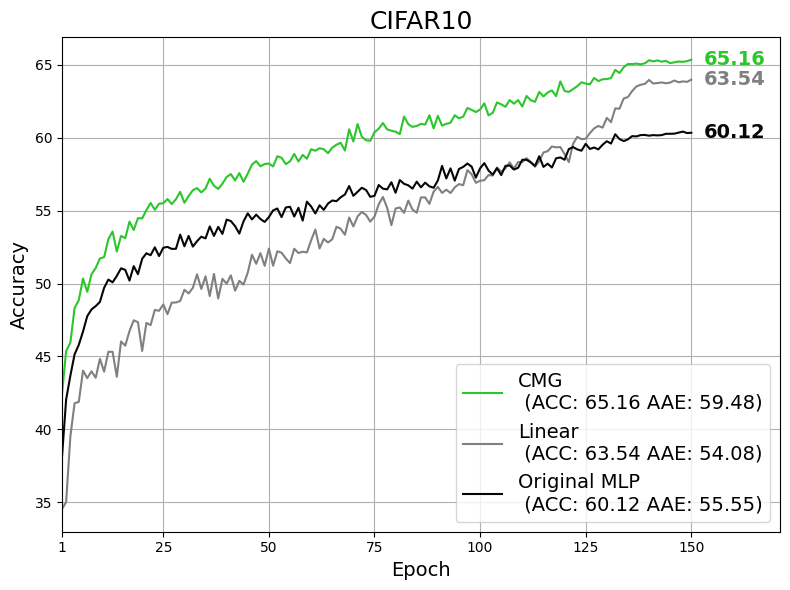

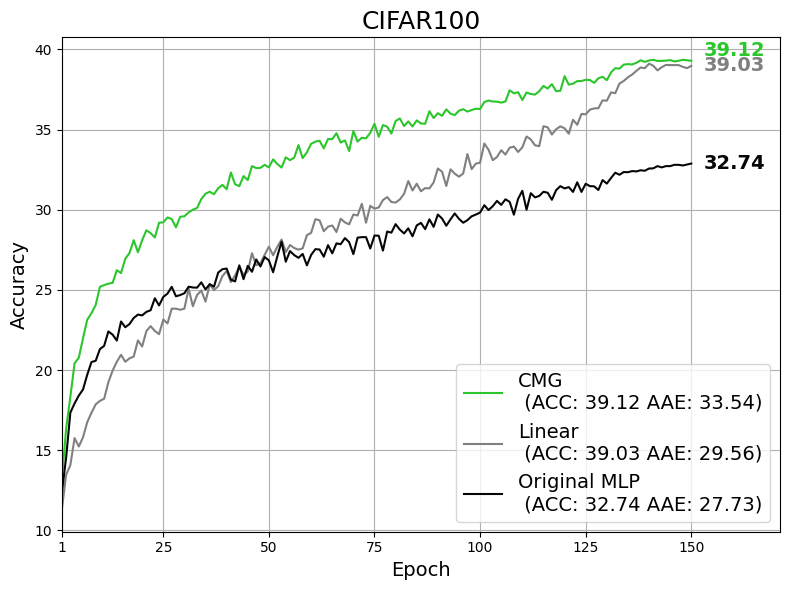

In [93]:
# Generate comparison plots for each dataset and single_param option
datasets = ['CIFAR10','CIFAR100']
networks = ['MLP_CIFAR10_A','MLP_CIFAR100_A']
modes = ['CM-GLLF-all-valuewise-minmax-mapping',
         'linear-valuewise-positive',
         ]
init_methods = ['uniform'] * len(modes)
# seeds = [0,1,2]
seeds = [0,1,2]
scheduler='power_to_linear'
for dataset, network in zip(datasets, networks):
    for single_param in [False]:
        plot_comparison_figure_with_annotations(
            dataset=dataset,
            network=network,
            modes=modes,
            init_methods=init_methods,
            seeds=seeds,
            epochs=150,
            scheduler=scheduler,
            colors=["#2bc62b", 'grey', "#060606"],  # Custom colors
            draw_mode='cmg+linear',
        )

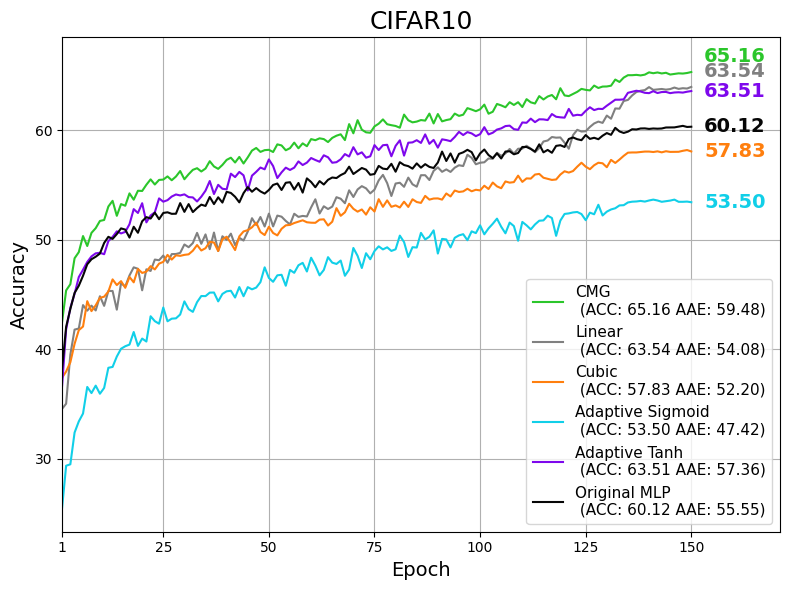

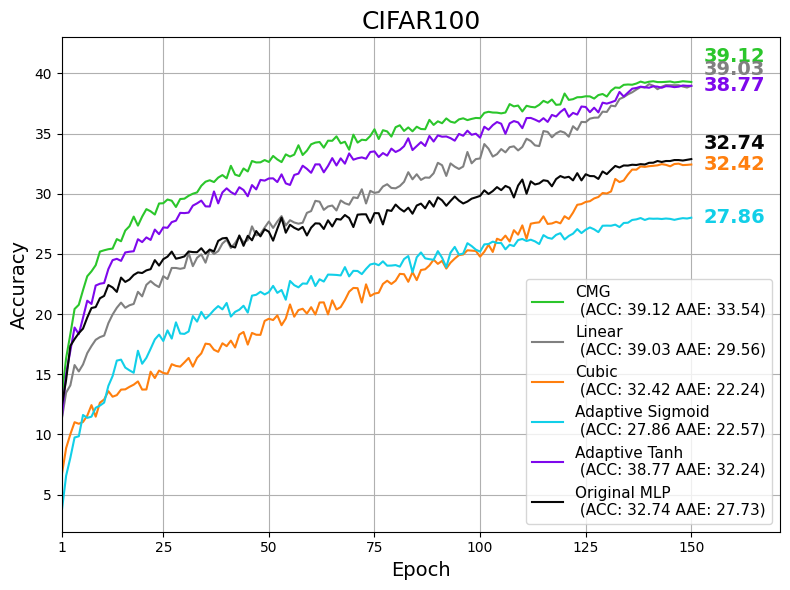

In [94]:
# Generate comparison plots for each dataset and single_param option
datasets = ['CIFAR10','CIFAR100']
networks = ['MLP_CIFAR10_A','MLP_CIFAR100_A']
modes = ['CM-GLLF-all-valuewise-minmax-mapping',
         'linear-valuewise-positive',
         'cubic-valuewise-positive',
         'adaptive-sigmoid-valuewise',
         'adaptive-tanh-valuewise',
        #  'srelu_valuewise_positive',
         ]
init_methods = ['uniform'] * len(modes)
# seeds = [0,1,2]
seeds = [0,1,2]
scheduler='power_to_linear'
for dataset, network in zip(datasets, networks):
    for single_param in [False]:
        plot_comparison_figure_with_annotations(
            dataset=dataset,
            network=network,
            modes=modes,
            init_methods=init_methods,
            seeds=seeds,
            epochs=150,
            scheduler=scheduler,
            colors=["#2bc62b", 'grey', '#ff7f0e', "#11cfe8","#7e08ec", "#060606"],  # Custom colors
            legend_fs=11,
            draw_mode='cmg+linear+adaptive',
        )

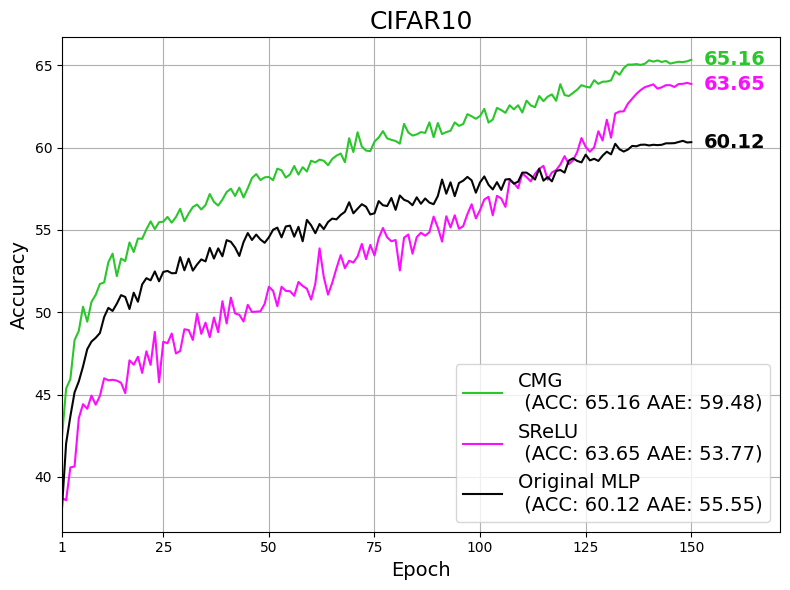

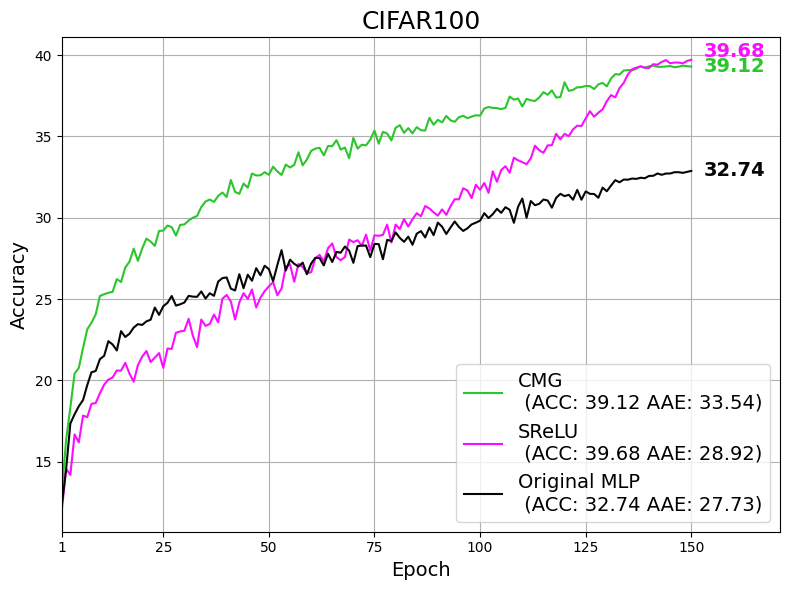

In [95]:
# Generate comparison plots for each dataset and single_param option
datasets = ['CIFAR10','CIFAR100']
networks = ['MLP_CIFAR10_A','MLP_CIFAR100_A']
modes = ['CM-GLLF-all-valuewise-minmax-mapping',
        #  'linear-valuewise-positive',
        #  'cubic-valuewise-positive',
        #  'adaptive-sigmoid-valuewise',
        #  'adaptive-tanh-valuewise',
         'srelu_valuewise_positive',
         ]
init_methods = ['uniform'] * len(modes)
# seeds = [0,1,2]
seeds = [0,1,2]
scheduler='power_to_linear'
for dataset, network in zip(datasets, networks):
    for single_param in [False]:
        plot_comparison_figure_with_annotations(
            dataset=dataset,
            network=network,
            modes=modes,
            init_methods=init_methods,
            seeds=seeds,
            epochs=150,
            scheduler=scheduler,
            colors=["#2bc62b","#fb0eff", "#060606"],  # Custom colors
            draw_mode='cmg+srelu',
        )

# compare schedulers

In [11]:
# first plot the scheduler shapes
# Scheduler factory mirroring train_tuner.py
import torch
def create_scheduler(optimizer, scheduler_type, epochs):
    if scheduler_type == 'linear':
        return torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=1.0, end_factor=0.01, total_iters=int(epochs * 0.9)
        )
    elif scheduler_type == 'exponential_95':
        stop_epoch = int(epochs * 0.9)
        return torch.optim.lr_scheduler.LambdaLR(
            optimizer, lambda epoch: 0.95 ** min(epoch, stop_epoch)
        )
    elif scheduler_type == 'exponential_97':
        stop_epoch = int(epochs * 0.9)
        return torch.optim.lr_scheduler.LambdaLR(
            optimizer, lambda epoch: 0.97 ** min(epoch, stop_epoch)
        )
    elif scheduler_type == 'exponential_99':
        stop_epoch = int(epochs * 0.9)
        return torch.optim.lr_scheduler.LambdaLR(
            optimizer, lambda epoch: 0.99 ** min(epoch, stop_epoch)
        )
    elif scheduler_type == 'slow_to_fast':
        # Piecewise multiplicative decay: slow early, faster later, capped at 90% of epochs
        stop_epoch = int(epochs * 0.9)
        half = max(1, stop_epoch // 2)
        def factor(epoch):
            e = min(epoch, stop_epoch)
            if e <= half:
                return (0.995) ** e
            else:
                # First half at 0.995, remaining at 0.95
                return (0.995 ** half) * (0.95 ** (e - half))
        return torch.optim.lr_scheduler.LambdaLR(optimizer, factor)
    elif scheduler_type == 'exp_symmetric_95':
        # Smooth slow-to-fast curve symmetric (in shape) to exponential decay, capped at 90% of epochs
        stop_epoch = int(epochs * 0.9)
        q = 2.0  # convex warp power; q>1 => slow start then faster end
        gamma = 0.95
        def factor(epoch):
            e = min(epoch, stop_epoch)
            if stop_epoch <= 0:
                return 1.0
            t = e / float(stop_epoch)
            g = t ** q  # convex time-warp
            return gamma ** (stop_epoch * g)
        return torch.optim.lr_scheduler.LambdaLR(optimizer, factor)
    elif scheduler_type == 'exponential_to_linear':
        # Exponential decay that reaches 0.01 at 90% of epochs (same as linear)
        stop_epoch = int(epochs * 0.9)
        # Calculate gamma such that gamma^stop_epoch = 0.01
        gamma = 0.01 ** (1.0 / stop_epoch)
        return torch.optim.lr_scheduler.LambdaLR(
            optimizer, lambda epoch: gamma ** min(epoch, stop_epoch)
        )
    elif scheduler_type == 'power_to_linear':
        stop_epoch = int(epochs * 0.9)
        power = 0.5  # You can adjust this power as needed
        def power_decay(epoch):
            if epoch >= stop_epoch:
                return 0.01
            t = epoch / stop_epoch
            return 0.01 + (1.0 - 0.01) * ((1 - t) ** power)
        return torch.optim.lr_scheduler.LambdaLR(optimizer, power_decay)        
    else:
        raise ValueError(f'Unknown scheduler type: {scheduler_type}')

/home/amax/.conda/envs/chts_wenqi/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


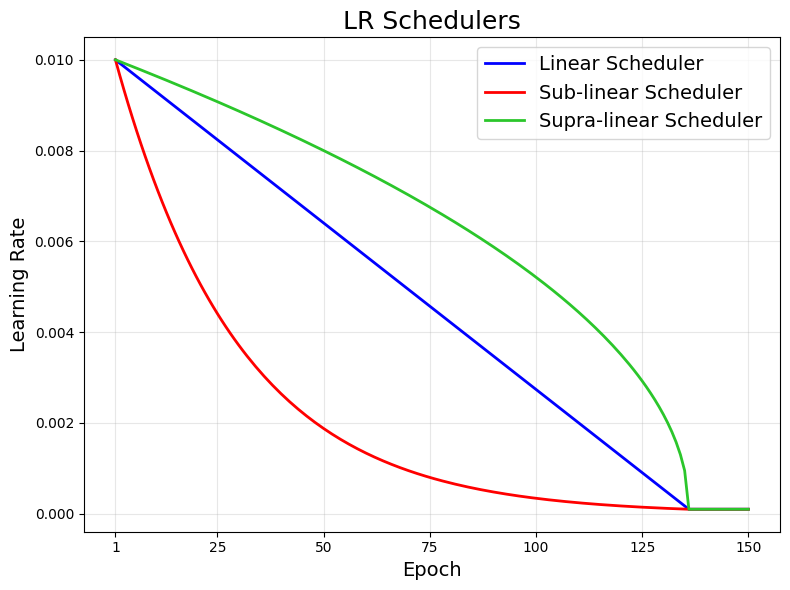

In [12]:
# Simulate and plot learning rates
epochs = 150
base_lr = 0.01  # choose a representative base learning rate
scheduler_types = ['linear', 'exponential_to_linear', 'power_to_linear']

lr_histories = {}
for sched_type in scheduler_types:
    # fresh model/optimizer per schedule to avoid cross-contamination
    model = torch.nn.Linear(1, 1)
    optimizer = torch.optim.SGD(model.parameters(), lr=base_lr)
    scheduler = create_scheduler(optimizer, sched_type, epochs)

    lrs = []
    for epoch in range(epochs):
        # record LR used this epoch (scheduler is stepped at the end of each epoch in train_tuner.py)
        lrs.append(optimizer.param_groups[0]['lr'])
        scheduler.step()
    lr_histories[sched_type] = lrs

# Plot
plt.figure(figsize=(8, 6))
for name, lrs in lr_histories.items():
    if name=='power_to_linear':
        name='Supra-linear Scheduler'
        color="#2bc62b"
    elif name=='exponential_to_linear':
        name='Sub-linear Scheduler'
        color='red'
    elif name=='linear':
        name='Linear Scheduler'
        color='blue'
    plt.plot(range(epochs), lrs, label=name,color=color,linewidth=2)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Learning Rate', fontsize=14)
plt.title('LR Schedulers', fontsize=18)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=14)

# Set x-ticks to match other figures
tick_positions = [pos -1 for pos in [1,25,50,75,100,125,150]]
tick_labels = [str(pos+1) for pos in tick_positions]
plt.xticks(tick_positions, tick_labels)

os.makedirs('plots', exist_ok=True)
plt.tight_layout()
plt.savefig('plots/lr_schedules_200epochs.png', dpi=180)
plt.show()

In [35]:
def plot_combined_scheduler_comparison(dataset, network, mode, init_method, epochs, seeds, schedulers,
                                     single_param=False, rectify=False, save_path=None, colors=None, **kwargs):
    """
    Plot comparison figure showing both tuned (solid lines) and no-tune (dashed lines) results
    for different schedulers in a single plot.
    """
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Define colors for different schedulers
    if colors is None:
        colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    # Collect results for both tuned and no-tune
    annotations = []  # Store annotation data for positioning
    
    for i, scheduler in enumerate(schedulers):
        color = colors[i % len(colors)]
        
        # Get tuned results
        tuned_result, _, tuned_avg_acc, tuned_avg_aae = find_best_tuned_result(
            dataset, network, mode, scheduler, epochs, seeds, init_method, **kwargs
        )
        
        # Get no-tune results
        notune_result, _, notune_avg_acc, notune_avg_aae = find_best_untuned_result(
            dataset, network, scheduler, epochs, seeds, **kwargs
        )
        
        # Clean scheduler name
        scheduler_label = scheduler
        if scheduler == 'linear':
            scheduler_label = 'Linear Scheduler'
        elif scheduler == 'exponential_to_linear':
            scheduler_label = 'Sub-linear Scheduler'
        elif scheduler == 'power_to_linear':
            scheduler_label = 'Supra-linear Scheduler'
        
        # Plot tuned results (solid line)
        if tuned_result is not None:
            test_top1_tuned = tuned_result['test']['top1']
            ax.plot(test_top1_tuned, color=color, linestyle='-', linewidth=2,
                   label=f'{scheduler_label} (CMG)\n (ACC:{tuned_avg_acc:.2f} AAE:{tuned_avg_aae:.2f})')
            
            # Store annotation data for tuned
            annotations.append({
                'x': len(test_top1_tuned) - 1,
                'y': test_top1_tuned[-1],
                'acc': tuned_avg_acc,
                'color': color,
                'text': f'{tuned_avg_acc:.2f}',
                'scheduler': scheduler,
                'type': 'tuned'
            })
        
        # Plot no-tune results (dashed line)
        if notune_result is not None:
            test_top1_notune = notune_result['test']['top1']
            ax.plot(test_top1_notune, color=color, linestyle=(0, (2, 2)), linewidth=2,
                label=f'{scheduler_label} (Original MLP)\n (ACC:{notune_avg_acc:.2f} AAE:{notune_avg_aae:.2f})')
            
            # Store annotation data for no-tune
            annotations.append({
                'x': len(test_top1_notune) - 1,
                'y': test_top1_notune[-1],
                'acc': notune_avg_acc,
                'color': color,
                'text': f'{notune_avg_acc:.2f}',
                'scheduler': scheduler,
                'type': 'notune'
            })
    
    # Extend x-axis to provide more space for annotations
    ax.set_xlim(left=0, right=epochs + 20)  # Add 15 units of padding to the right
    
    # Sort annotations by accuracy (highest first) for proper vertical positioning
    annotations.sort(key=lambda x: x['acc'], reverse=True)
    
    # Add annotations with improved positioning logic
    y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
    base_spacing = 0.008 * y_range  # Base vertical spacing between annotations
    
    for i, ann in enumerate(annotations):
        # Calculate text position with special handling for supra-linear scheduler
        base_y = ann['y']
        
        # Give supra-linear (power_to_linear) extra height to avoid overlap
        if ann['scheduler'] == 'power_to_linear' and ann['type'] == 'tuned':
            # Position supra-linear tuned result higher
            adjusted_y = base_y + (i + 3) * base_spacing
        elif ann['scheduler'] == 'power_to_linear' and ann['type'] == 'notune':
            # Position supra-linear tuned result higher
            adjusted_y = base_y + (i) * base_spacing            
        else:
            # adjusted_y = base_y + i * base_spacing
            adjusted_y = base_y
        
        # Position text further to the right with more padding
        text_x = ann['x'] + 4
        
        ax.annotate(ann['text'], 
                   xy=(ann['x'], ann['y']), 
                   xytext=(text_x, adjusted_y),
                   color=ann['color'], 
                   fontsize=14, 
                   fontweight='bold',
                   verticalalignment='center')
    
    # Set titles and labels
    ax.set_title(f'Scheduler Accuracy Comparison', fontsize=18)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    
    # Set x-ticks to match other figures
    tick_positions = [pos -1 for pos in [1,25,50,75,100,125,150]]
    tick_labels = [str(pos+1) for pos in tick_positions]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)
    
    ax.legend(fontsize=11)
    ax.grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved as: {save_path}")
    
    plt.show()

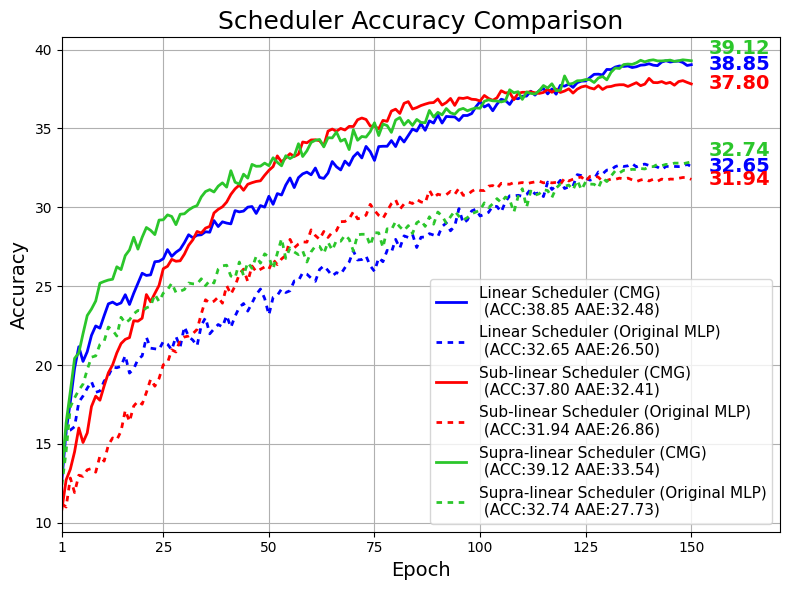

In [36]:
# Generate combined scheduler comparison plot

plot_combined_scheduler_comparison(
    dataset="CIFAR100",
    network="MLP_CIFAR100_A",
    mode='CM-GLLF-all-valuewise-minmax-mapping',
    init_method='uniform', 
    epochs=150, 
    seeds=[0,1,2], 
    schedulers=['linear', 'exponential_to_linear', 'power_to_linear'],
    colors=['blue', 'red', "#2bc62b"]
)

# Qualitative test

In [15]:
from models_tuner import MLP_CIFAR10_A, MLP_CIFAR100_A
import torch

def get_best_model(dataset, network, mode, scheduler, epochs, seeds, init_method):
    _, best_params, _, _ = find_best_tuned_result(dataset, network, mode, scheduler, epochs, seeds, init_method)
    # get the path
    result_path, _ = get_fname_tuner(
                            dataset, network, best_params['batch_size'], best_params['lr_w'],
                            best_params['lr_special'], epochs, best_params['seed'],
                            True, mode, True, init_method, 5e-4, 
                            False, False, scheduler_w=scheduler
                        )   
    model_path = os.path.join(result_path, 'best_model.pth')
    if os.path.exists(model_path):
        # Create the model architecture
        if network == 'MLP_CIFAR10_A':
            from models_tuner import MLP_CIFAR10_A
            model = MLP_CIFAR10_A(3072, 10, True, mode, True, init_method, dataset, single_param=False)
        elif network == 'MLP_CIFAR100_A':
            from models_tuner import MLP_CIFAR100_A
            model = MLP_CIFAR100_A(3072, 100, True, mode, True, init_method, dataset, single_param=False)    
    else:
        raise FileNotFoundError(f"Model file not found: {model_path}")
    # Load the trained parameters
    state_dict = torch.load(model_path, map_location='cpu')
    model.load_state_dict(state_dict)
    results = {}
    # Extract tuner parameters
    if hasattr(model, 'tuner'):
        tuner = model.tuner
        tuner_class_name = tuner.__class__.__name__
        
        print(f"Detected tuner type: {tuner_class_name}")
        results['tuner_type'] = tuner_class_name
        results['tuner'] = tuner  # Store the tuner itself for direct use
        
        if tuner_class_name == 'CM_GLLF_tuner_flexible':
            if hasattr(tuner, 'mu_raw'):
                mu_raw = tuner.mu_raw.detach().cpu()
                # Transform based on tuner mode
                if tuner.mode == 'all':
                    mu = torch.sigmoid(mu_raw)
                elif tuner.mode == 'logistic':
                    mu = 0.5 * torch.sigmoid(mu_raw)
                elif tuner.mode == 'logit':
                    mu = 0.5 + 0.5 * torch.sigmoid(mu_raw)
                else:
                    raise ValueError(f"Unknown mode: {tuner.mode}")
                results['mu_raw'] = mu_raw
                results['mu'] = mu
                print(f"Parameter 'mu_raw' shape: {results['mu_raw'].shape}")
                print(f"Parameter 'mu' shape: {results['mu'].shape}")
                print(f"mu range: [{results['mu'].min():.4f}, {results['mu'].max():.4f}]")
            
            if hasattr(tuner, 'I_raw'):
                I_raw = tuner.I_raw.detach().cpu()
                # Transform: I = sigmoid(I_raw)
                I = torch.sigmoid(I_raw)
                results['I_raw'] = I_raw
                results['I'] = I
                print(f"Parameter 'I_raw' shape: {results['I_raw'].shape}")
                print(f"Parameter 'I' shape: {results['I'].shape}")
                print(f"I range: [{results['I'].min():.4f}, {results['I'].max():.4f}]")
        
        # Handle tuners with 'a' and 'b' parameters
        elif tuner_class_name in ['Linear_tuner_valuewise', 'Cubic_tuner_valuewise', 'AdaptiveClassic_tuner_valuewise']:
            # Handle 'a' parameter
            if hasattr(tuner, 'a_raw'):
                a_raw = tuner.a_raw.detach().cpu()
                if tuner.positive_a:
                    a = torch.exp(a_raw)  # For positive_a=True, a = exp(a_raw)
                else:
                    a = a_raw  # For positive_a=False, a is used directly
                results['a_raw'] = a_raw
                results['a'] = a
                print(f"Parameter 'a_raw' shape: {results['a_raw'].shape}")
                print(f"Parameter 'a' shape: {results['a'].shape}")
                print(f"a range: [{results['a'].min():.4f}, {results['a'].max():.4f}]")
            elif hasattr(tuner, 'a'):
                a = tuner.a.detach().cpu()
                results['a'] = a
                print(f"Parameter 'a' shape: {results['a'].shape}")
                print(f"a range: [{results['a'].min():.4f}, {results['a'].max():.4f}]")
            
            # Handle 'b' parameter
            if hasattr(tuner, 'b'):
                b = tuner.b.detach().cpu()
                results['b'] = b
                print(f"Parameter 'b' shape: {results['b'].shape}")
                print(f"b range: [{results['b'].min():.4f}, {results['b'].max():.4f}]")
        
        # Handle SReLU tuners with different parameter names
        elif 'SReLU' in tuner_class_name:
            if hasattr(tuner, 't_left'):
                results['t_left'] = tuner.t_left.detach().cpu()
                print(f"Parameter 't_left' shape: {results['t_left'].shape}")
                print(f"t_left range: [{results['t_left'].min():.4f}, {results['t_left'].max():.4f}]")
            
            if hasattr(tuner, 't_right'):
                results['t_right'] = tuner.t_right.detach().cpu()
                print(f"Parameter 't_right' shape: {results['t_right'].shape}")
                print(f"t_right range: [{results['t_right'].min():.4f}, {results['t_right'].max():.4f}]")
            
            # Handle slope parameters (a_left, a_right)
            if hasattr(tuner, 'a_left_raw'):
                a_left_raw = tuner.a_left_raw.detach().cpu()
                a_left = torch.exp(a_left_raw) if tuner.positive_slopes else a_left_raw
                results['a_left_raw'] = a_left_raw
                results['a_left'] = a_left
                print(f"Parameter 'a_left' range: [{results['a_left'].min():.4f}, {results['a_left'].max():.4f}]")
            elif hasattr(tuner, 'a_left'):
                results['a_left'] = tuner.a_left.detach().cpu()
                print(f"Parameter 'a_left' range: [{results['a_left'].min():.4f}, {results['a_left'].max():.4f}]")
            
            if hasattr(tuner, 'a_right_raw'):
                a_right_raw = tuner.a_right_raw.detach().cpu()
                a_right = torch.exp(a_right_raw) if tuner.positive_slopes else a_right_raw
                results['a_right_raw'] = a_right_raw
                results['a_right'] = a_right
                print(f"Parameter 'a_right' range: [{results['a_right'].min():.4f}, {results['a_right'].max():.4f}]")
            elif hasattr(tuner, 'a_right'):
                results['a_right'] = tuner.a_right.detach().cpu()
                print(f"Parameter 'a_right' range: [{results['a_right'].min():.4f}, {results['a_right'].max():.4f}]")
        
        else:
            print(f"Warning: Unknown tuner type '{tuner_class_name}'. Only basic info extracted.")
    else:
        raise ValueError("The model to inspect should have attr tuner")    
    return results

In [16]:
def plot_tuner_heatmaps(mu_tensor, I_tensor, height=32, width=32, channels=3,
                        channel_names=None, cmap=None, channel_cmaps=None,
                        title=None, figsize=(12, 8)):
    """Visualize tuner parameters as 2xN heatmaps (mu row, I row, channel columns).

    Parameters
    ----------
    mu_tensor : torch.Tensor or array-like
        Tuner parameter, expected as a flat vector of length ``height*width*channels``
        or already reshaped to (channels, height, width).
    I_tensor : torch.Tensor or array-like
        Tuner parameter I with the same layout constraints as ``mu_tensor``.
    height, width : int
        Spatial dimensions for the resulting heatmaps (default: 32x32 for CIFAR).
    channels : int
        Number of color channels to visualize (default: 3 for RGB).
    channel_names : list[str] | None
        Optional list of labels per channel; defaults to ['R', 'G', 'B'] when channels==3,
        otherwise ['Channel 1', ...].
    cmap : str | matplotlib.colors.Colormap | Sequence | None
        Shared colormap applied to every channel if provided. When ``None`` and ``channel_cmaps``
        is also ``None``, RGB channels default to Reds/Greens/Blues so higher values render darker.
    channel_cmaps : Sequence[str | matplotlib.colors.Colormap] | None
        Optional per-channel colormap overrides. Must match ``channels`` in length.
    title : str | None
        Optional figure title.
    figsize : tuple
        Figure size forwarded to ``plt.subplots``.
    """
    import torch
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import LinearSegmentedColormap
    
    # Create custom colormap: black -> white (at 0.5) -> red
    colors = ['black', 'white', 'red']
    n_bins = 256
    custom_cmap = LinearSegmentedColormap.from_list('custom_bwr', colors, N=n_bins)

    def _to_channel_maps(tensor, name):
        if tensor is None:
            raise ValueError(f"{name} must not be None")
        if isinstance(tensor, torch.Tensor):
            data = tensor.detach().cpu().numpy()
        else:
            data = np.asarray(tensor)

        if data.ndim == 1:
            expected = height * width * channels
            if data.size != expected:
                raise ValueError(
                    f"Flat {name} length {data.size} cannot be reshaped to ({channels}, {height}, {width})"
                )
            data = data.reshape(channels, height, width)
        else:
            raise ValueError(
                f"{name} must be 1D flat, 2D flattened, or 3D channel-first arrays; got ndim={data.ndim}."
            )

        return data

    def _resolve_cmap(entry):
        if isinstance(entry, str):
            return plt.get_cmap(entry)
        if entry is None:
            raise ValueError("Colormap entries must not be None")
        return entry

    mu_maps = _to_channel_maps(mu_tensor, "mu")
    I_maps = _to_channel_maps(I_tensor, "I")

    if mu_maps.shape != I_maps.shape:
        raise ValueError(
            f"mu and I must share the same shape after reshaping; got {mu_maps.shape} vs {I_maps.shape}."
        )

    if channel_names is None:
        if channels == 3:
            channel_names = ["R", "G", "B"]
        else:
            channel_names = [f"Channel {idx + 1}" for idx in range(channels)]
    if len(channel_names) != channels:
        raise ValueError("channel_names length must match the number of channels")

    # Use the custom colormap for all channels
    resolved_cmaps = [custom_cmap for _ in range(channels)]

    # Create figure with RGB composite column
    fig, axes = plt.subplots(2, channels + 1, figsize=(figsize[0] + 4, figsize[1]))
    if title:
        fig.suptitle(title, fontsize=16)

    for col in range(channels):
        cmap_to_use = resolved_cmaps[col]
        mu_im = axes[0, col].imshow(mu_maps[col], cmap=cmap_to_use, vmin=0, vmax=1)
        axes[0, col].axis('off')
        mu_cbar = fig.colorbar(mu_im, ax=axes[0, col], fraction=0.046, pad=0.04)
        mu_cbar.set_ticks([0, 0.5, 1])

        I_im = axes[1, col].imshow(I_maps[col], cmap=cmap_to_use, vmin=0, vmax=1)
        axes[1, col].axis('off')
        I_cbar = fig.colorbar(I_im, ax=axes[1, col], fraction=0.046, pad=0.04)
        I_cbar.set_ticks([0, 0.5, 1])

    # Create RGB composite images
    if channels == 3:
        # Create RGB composite for μ
        mu_rgb = np.stack([mu_maps[0], mu_maps[1], mu_maps[2]], axis=-1)
        axes[0, channels].imshow(mu_rgb, vmin=0, vmax=1)
        axes[0, channels].axis('off')
        
        # Create RGB composite for I
        I_rgb = np.stack([I_maps[0], I_maps[1], I_maps[2]], axis=-1)
        axes[1, channels].imshow(I_rgb, vmin=0, vmax=1)
        axes[1, channels].axis('off')
    else:
        # For non-RGB cases, create grayscale composite
        mu_composite = np.mean(mu_maps, axis=0)
        axes[0, channels].imshow(mu_composite, cmap='gray', vmin=0, vmax=1)
        axes[0, channels].axis('off')
        
        I_composite = np.mean(I_maps, axis=0)
        axes[1, channels].imshow(I_composite, cmap='gray', vmin=0, vmax=1)
        axes[1, channels].axis('off')

    # Add column headers (R, G, B, RGB Composite) at the top
    for col in range(channels):
        axes[0, col].set_title(channel_names[col], fontsize=20, pad=10)
    
    # Add header for RGB composite column
    composite_title = "RGB Composite" if channels == 3 else "Composite"
    axes[0, channels].set_title(composite_title, fontsize=20, pad=10)

    # Add row labels (μ, I) on the left - temporarily turn on axis for labels
    for row in range(2):
        axes[row, 0].axis('on')
        axes[row, 0].set_xticks([])
        axes[row, 0].set_yticks([])
        # Remove spines to keep clean look
        for spine in axes[row, 0].spines.values():
            spine.set_visible(False)
    
    axes[0, 0].set_ylabel('μ', fontsize=20, rotation=0, labelpad=30, ha='center', va='center')
    axes[1, 0].set_ylabel('I', fontsize=20, rotation=0, labelpad=30, ha='center', va='center')
    
    fig.tight_layout(rect=(0, 0, 1, 0.97) if title else None)
    plt.subplots_adjust(left=0.1)  # Add more space on the left for row labels
    # return fig


In [17]:
def create_cifar10_transformation_grid(tuner_a,
                                        tuner_b,
                                        show_grayscale=False,
                                        samples_per_class=1,
                                        dataset_root='./data',
                                        title=None,
                                        labels=None,
                                        figsize=(24, 8),
                                        verbose=True):
    """Create a 3-row grid comparing original images with two tuner outputs.
    
    Parameters:
    -----------
    tuner_a, tuner_b : torch.nn.Module or dict
        Either callable tuner modules or dict specs with 'mu'/'I' parameters
    show_grayscale : bool
        Whether to display images in grayscale
    samples_per_class : int
        Number of samples per CIFAR-10 class to display
    dataset_root : str
        Path to CIFAR-10 dataset
    title : str, optional
        Figure title
    labels : list of str, optional
        Labels for the two tuners. If None, uses default labels.
    figsize : tuple
        Figure size
    verbose : bool
        Whether to print min/max values during processing
    """
    import torch
    import numpy as np
    import matplotlib.pyplot as plt
    from torchvision import datasets, transforms
    from tuners import CM_GLLF_tuner_flexible
    tuner_a.eval()
    tuner_b.eval()
    if samples_per_class < 1:
        raise ValueError("samples_per_class must be >= 1")

    device = torch.device('cpu')

    # Validate labels
    if labels is not None and len(labels) != 2:
        raise ValueError("labels must contain exactly two entries when provided")

    # CIFAR-10 normalization constants
    mean = torch.tensor([0.4914, 0.4822, 0.4465], dtype=torch.float32, device=device).view(3, 1, 1)
    std = torch.tensor([0.2470, 0.2435, 0.2616], dtype=torch.float32, device=device).view(3, 1, 1)

    def _apply_transform(module, normalized_tensor):
        """Apply tuner transformation to normalized image tensor"""
        original_shape = normalized_tensor.shape
        # batch_size = normalized_tensor.shape[0]
        flat = normalized_tensor.view(1, -1)
        with torch.no_grad():
            output = module(flat)
        return output.view(original_shape)

    def _prepare_for_display(tensor):
        """Convert normalized tensor back to displayable format"""
        unnormalized = tensor * std + mean
        if verbose:
            min_val = float(unnormalized.min())
            max_val = float(unnormalized.max())
            print(f"Display tensor range: [{min_val:.4f}, {max_val:.4f}]")
        return unnormalized.clamp(0.0, 1.0)

    # Load CIFAR-10 dataset
    dataset = datasets.CIFAR10(root=dataset_root, train=False, download=True, 
                              transform=transforms.ToTensor())
    class_names = dataset.classes

    # Collect samples by class
    samples_by_class = {cls: [] for cls in range(10)}
    for image, label in dataset:
        if len(samples_by_class[label]) < samples_per_class:
            samples_by_class[label].append(image.to(device))
            if all(len(v) >= samples_per_class for v in samples_by_class.values()):
                break

    # Validate we have enough samples
    if any(len(v) < samples_per_class for v in samples_by_class.values()):
        raise RuntimeError(
            "Unable to gather the requested number of samples for every class; "
            "try reducing samples_per_class or ensuring the dataset is available."
        )

    # Setup plotting
    total_cols = 10 * samples_per_class
    fig, axes = plt.subplots(3, total_cols, figsize=figsize)
    if total_cols == 1:
        axes = axes.reshape(3, 1)

    def _show_image(ax, tensor, title_text=None):
        """Display image tensor on given axis"""
        if show_grayscale:
            from torchvision.transforms.functional import rgb_to_grayscale
            # Convert RGB to grayscale using standard weights
            grayscale_tensor = rgb_to_grayscale(tensor, num_output_channels=1)

            # Convert to NumPy for displaying with matplotlib
            gray_img = grayscale_tensor.squeeze().cpu().numpy()
            ax.imshow(gray_img, cmap='gray', vmin=0.0, vmax=1.0)
        else:
            # Display color image (convert CHW to HWC)
            img_array = tensor.cpu().permute(1, 2, 0).numpy()
            ax.imshow(np.clip(img_array, 0, 1))  # Ensure valid range
        
        ax.axis('off')
        if title_text:
            ax.set_title(title_text, fontsize=10, pad=2)

    # Generate the grid
    tuners = (tuner_a, tuner_b)
    col_idx = 0
    for cls in range(10):
        for sample_idx, original in enumerate(samples_by_class[cls], start=1):
            # Normalize input image
            normalized = (original - mean) / std

            # Show original image
            original_disp = _prepare_for_display(normalized)
            title_text = class_names[cls] if samples_per_class == 1 else f"{class_names[cls]} #{sample_idx}"
            _show_image(axes[0, col_idx], original_disp, title_text)

            # Apply each tuner transformation
            for row_offset, module in enumerate(tuners, start=1):
                try:
                    transformed = _apply_transform(module, normalized)
                    transformed_disp = _prepare_for_display(transformed)
                    _show_image(axes[row_offset, col_idx], transformed_disp)
                except Exception as e:
                    print(f"Error applying tuner {row_offset} to image {cls}-{sample_idx}: {e}")
                    # Show a black image on error
                    _show_image(axes[row_offset, col_idx], torch.zeros_like(original_disp))

            col_idx += 1

    # Set row labels
    axes[0, 0].set_ylabel('Original', fontsize=12, rotation=90, labelpad=10)
    # for row_offset, label in enumerate(labels):
    #     axes[row_offset, 0].set_ylabel(label, fontsize=12, rotation=90, labelpad=10)

    # Set title
    if title:
        fig.suptitle(title, fontsize=16, y=0.98)

    # Adjust layout
    fig.tight_layout(rect=(0, 0, 1, 0.96) if title else None)
    plt.subplots_adjust(hspace=0.1, wspace=0.05)

In [18]:
def create_detailed_comparison_figure(tuner, class_name, show_gray=False, normalize_way='clamp', dataset_root='./data', figsize=(15, 5)):
    """
    Create a detailed comparison figure for a single image showing:
    1. Original image
    2. CM-GLLF transformed image 
    3. Global contrast comparison (bar plot) - using grayscale (luma)
    4. Pixel intensity distribution comparison - using grayscale (luma)
    
    Parameters:
    -----------
    tuner : torch.nn.Module
        The CM-GLLF tuner model
    class_name : str
        CIFAR-10 class name (default: 'dog')
    dataset_root : str
        Path to CIFAR-10 dataset
    figsize : tuple
        Figure size
    """
    import torch
    import numpy as np
    import matplotlib.pyplot as plt
    from torchvision import datasets, transforms
    from torchvision.transforms.functional import rgb_to_grayscale
    
    # Load CIFAR-10 dataset
    dataset = datasets.CIFAR10(root=dataset_root, train=False, download=True, 
                              transform=transforms.ToTensor())
    class_names = dataset.classes
    
    # Find the class index
    if class_name not in class_names:
        raise ValueError(f"Class '{class_name}' not found. Available classes: {class_names}")
    class_idx = class_names.index(class_name)
    
    # Get first image from the specified class
    original_image = None
    for image, label in dataset:
        if label == class_idx:
            original_image = image
            break
    
    if original_image is None:
        raise ValueError(f"No image found for class '{class_name}'")
    
    # CIFAR-10 normalization constants
    device = torch.device('cpu')
    mean = torch.tensor([0.4914, 0.4822, 0.4465], dtype=torch.float32, device=device).view(3, 1, 1)
    std = torch.tensor([0.2470, 0.2435, 0.2616], dtype=torch.float32, device=device).view(3, 1, 1)
    
    # Normalize and apply transformation
    normalized = (original_image - mean) / std
    
    # Apply CM-GLLF transformation
    tuner.eval()
    original_shape = normalized.shape
    flat = normalized.view(1, -1)
    with torch.no_grad():
        transformed_flat = tuner(flat)
    transformed = transformed_flat.view(original_shape)
    
    # Convert back to unnormalized format
    def unnormalize_tensor(tensor):
        """Convert normalized tensor back to original range without clamping"""
        return tensor * std + mean
    
    # Normalize to [0,1] range using min-max normalization instead of clamping
    def normalize_rescale(tensor):
        """Normalize tensor to [0,1] range for display.

        If all values in the unnormalized tensor already lie strictly within (0,1)
        (allowing a small epsilon tolerance), skip min-max normalization and just
        clamp to [0,1]. Otherwise perform min-max normalization as before.
        """
        unnormalized = unnormalize_tensor(tensor)

        # Small tolerance to treat values extremely close to 0/1 as inside (0,1)
        min_val = float(unnormalized.min())
        max_val = float(unnormalized.max())

        # Check if all values are strictly within (0,1) up to tolerance
        if (min_val > 0.0) and (max_val < 1.0):
            # Already in (0,1) — no normalization needed, just clamp for safety
            print(f"Unnormalized range: [{min_val:.6f}, {max_val:.6f}] -> Values already in (0,1), skipping min-max normalization.")
            return unnormalized.clamp(0.0, 1.0)

        # Otherwise perform min-max normalization to [0,1]
        if max_val > min_val:
            normalized = (unnormalized - min_val) / (max_val - min_val)
            print(f"Unnormalized range: [{min_val:.6f}, {max_val:.6f}] -> Min-max normalized to [0,1].")
            return normalized
        else:
            # Edge case: nearly constant tensor — return zeros to avoid NaNs
            print(f"Unnormalized range: [{min_val:.6f}, {max_val:.6f}] -> Nearly constant, returning zeros.")
            return torch.zeros_like(unnormalized)
    def normalize_rescale_all(tensor):
        """Normalize tensor to [0,1] range for display.

        If all values in the unnormalized tensor already lie strictly within (0,1)
        (allowing a small epsilon tolerance), skip min-max normalization and just
        clamp to [0,1]. Otherwise perform min-max normalization as before.
        """
        unnormalized = unnormalize_tensor(tensor)

        # Small tolerance to treat values extremely close to 0/1 as inside (0,1)
        min_val = float(unnormalized.min())
        max_val = float(unnormalized.max())
        normalized = (unnormalized - min_val) / (max_val - min_val)
        print(f"Unnormalized range: [{min_val:.6f}, {max_val:.6f}] -> Min-max normalized to [0,1].")
        return normalized     
        
    def normalize_clamp(tensor):
        unnormalized = unnormalize_tensor(tensor)
        return unnormalized.clamp(0.0,1.0)
    
    if normalize_way=='rescale':
        original_display = normalize_rescale(normalized)
        transformed_display = normalize_rescale(transformed)
    elif normalize_way=='clamp':
        original_display = normalize_clamp(normalized)
        transformed_display = normalize_clamp(transformed)  
    elif normalize_way=='rescale_all':
        original_display = normalize_rescale_all(normalized)
        transformed_display = normalize_rescale_all(transformed)          
    else:
        raise ValueError('Invalid normalize way!')      
    
    # Convert to grayscale for luminance analysis (luma approximation)
    def rgb_to_luminance(rgb_tensor):
        """Convert RGB tensor to grayscale (luma) using standard weights (BT.601-like)."""
        return rgb_to_grayscale(rgb_tensor, num_output_channels=1).squeeze(0)
    
    original_gray = rgb_to_luminance(original_display)
    transformed_gray = rgb_to_luminance(transformed_display)
    
    # Calculate global contrast (RMS contrast) on grayscale
    def calculate_rms_contrast_gray(gray_tensor):
        """Calculate RMS contrast (std dev of grayscale/luma) for a single image."""
        gray_np = gray_tensor.cpu().numpy()
        mean_intensity = np.mean(gray_np)
        rms_contrast = np.sqrt(np.mean((gray_np - mean_intensity) ** 2))
        return rms_contrast
    
    original_contrast = calculate_rms_contrast_gray(original_gray)
    transformed_contrast = calculate_rms_contrast_gray(transformed_gray)
    
    # Create figure with subplots
    # fig, axes = plt.subplots(1, 4, figsize=figsize)
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # 1. Original image (RGB)
    if show_gray:
        display_img = original_gray.squeeze().cpu().numpy()
        axes[0].imshow(display_img,cmap='gray', vmin=0.0, vmax=1.0)
    else:
        display_img = original_display.cpu().permute(1, 2, 0).numpy()
        axes[0].imshow(display_img)
    axes[0].set_title(f'Original', fontsize=22)
    axes[0].axis('off')
    
    # 2. Transformed image (RGB)
    if show_gray:
        display_img = transformed_gray.squeeze().cpu().numpy()
        axes[1].imshow(display_img,cmap='gray', vmin=0.0, vmax=1.0)
    else:
        display_img = transformed_display.cpu().permute(1, 2, 0).numpy()
        axes[1].imshow(display_img)
    axes[1].set_title('CMG Modulated', fontsize=22)
    axes[1].axis('off')
    
    # 3. Global contrast comparison (bar plot) - grayscale luminance
    contrast_values = [original_contrast, transformed_contrast]
    labels = ['Original', 'CMG']
    colors = ["#060606", "#2bc62b"]
    
    bars = axes[2].bar(labels, contrast_values, color=colors, alpha=0.7)
    axes[2].set_ylabel('RMS Contrast',fontsize=16)
    axes[2].set_title('RMS Contrast (Luma)',fontsize=22)
    axes[2].grid(True, alpha=0.3)
    axes[2].set_ylim(bottom=0.1)
    axes[2].tick_params(axis='x', labelsize=16) 
    
    # Add value labels on bars
    for bar, value in zip(bars, contrast_values):
        height = bar.get_height()
        axes[2].annotate(f'{value:.4f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points",
                        ha='center', va='bottom', fontsize=16)
    
    # 4. Pixel intensity distribution comparison - grayscale (luma)
    orig_gray_flat = original_gray.cpu().numpy().flatten()
    trans_gray_flat = transformed_gray.cpu().numpy().flatten()
    
    # Create smoothed density curves using KDE
    from scipy.stats import gaussian_kde
    
    # Create x-axis for smooth curves
    x_min = min(orig_gray_flat.min(), trans_gray_flat.min())
    x_max = max(orig_gray_flat.max(), trans_gray_flat.max())
    x = np.linspace(x_min, x_max, 200)
    
    # Compute KDE for both distributions
    kde_orig = gaussian_kde(orig_gray_flat)
    kde_trans = gaussian_kde(trans_gray_flat)
    
    # Plot smooth curves
    # axes[3].plot(x, kde_orig(x), label='Original', color="#060606", linewidth=2)
    # axes[3].plot(x, kde_trans(x), label='CMG', color="#2bc62b", linewidth=2)
    # axes[3].set_xlabel('Luma',fontsize=16)
    # axes[3].set_ylabel('Density',fontsize=16)
    # axes[3].set_title('Luma Distribution',fontsize=22)
    # axes[3].legend(fontsize=16)
    # axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n=== Analysis Summary for {class_name.capitalize()} ===")
    print("Global contrast (RMS on grayscale/luma):")
    print(f"  Original = {original_contrast:.6f}")
    print(f"  CM-GLLF  = {transformed_contrast:.6f}")
    print(f"  Change   = {((transformed_contrast - original_contrast) / original_contrast * 100):+.2f}%")
    
    print(f"\nGrayscale (luma) intensity statistics:")
    print(f"  Original: Mean = {orig_gray_flat.mean():.6f}, Std = {orig_gray_flat.std():.6f}")
    print(f"  CM-GLLF:  Mean = {trans_gray_flat.mean():.6f}, Std = {trans_gray_flat.std():.6f}")
    print(f"  Mean Change: {((trans_gray_flat.mean() - orig_gray_flat.mean()) / orig_gray_flat.mean() * 100):+.2f}%")
    print(f"  Std Change:  {((trans_gray_flat.std() - orig_gray_flat.std()) / orig_gray_flat.std() * 100):+.2f}%")

/tmp/ipykernel_2786508/2510650916.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location='cpu')


Detected tuner type: CM_GLLF_tuner_flexible
Parameter 'mu_raw' shape: torch.Size([3072])
Parameter 'mu' shape: torch.Size([3072])
mu range: [0.1894, 0.7608]
Parameter 'I_raw' shape: torch.Size([3072])
Parameter 'I' shape: torch.Size([3072])
I range: [0.0001, 0.9994]


Files already downloaded and verified


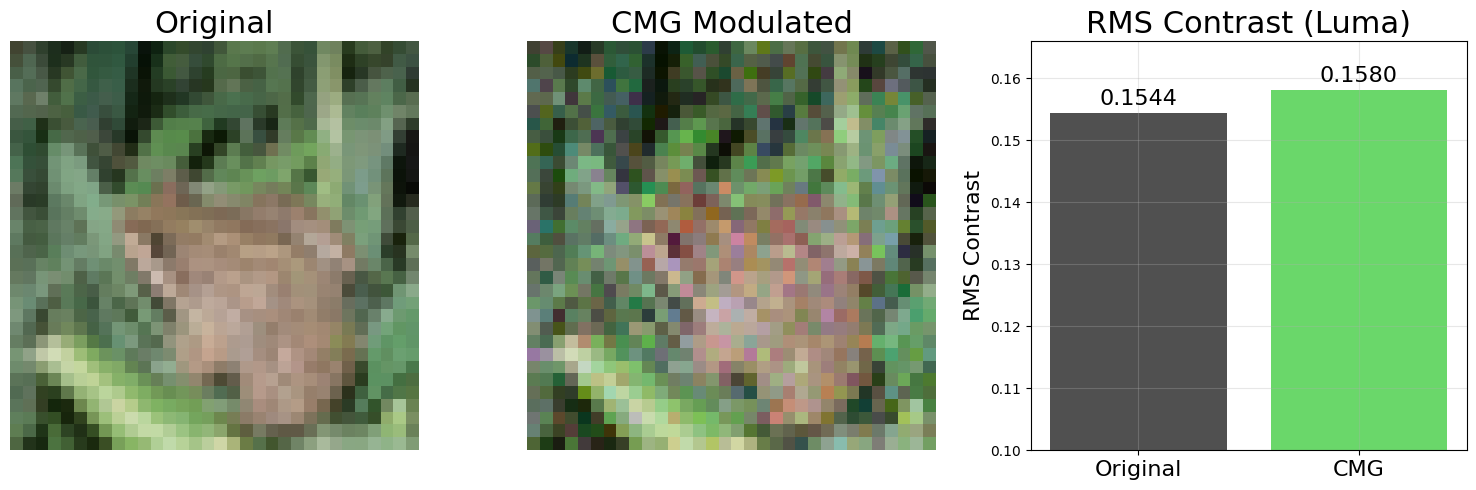


=== Analysis Summary for Frog ===
Global contrast (RMS on grayscale/luma):
  Original = 0.154411
  CM-GLLF  = 0.158039
  Change   = +2.35%

Grayscale (luma) intensity statistics:
  Original: Mean = 0.448626, Std = 0.154411
  CM-GLLF:  Mean = 0.448327, Std = 0.158039
  Mean Change: -0.07%
  Std Change:  +2.35%
Files already downloaded and verified


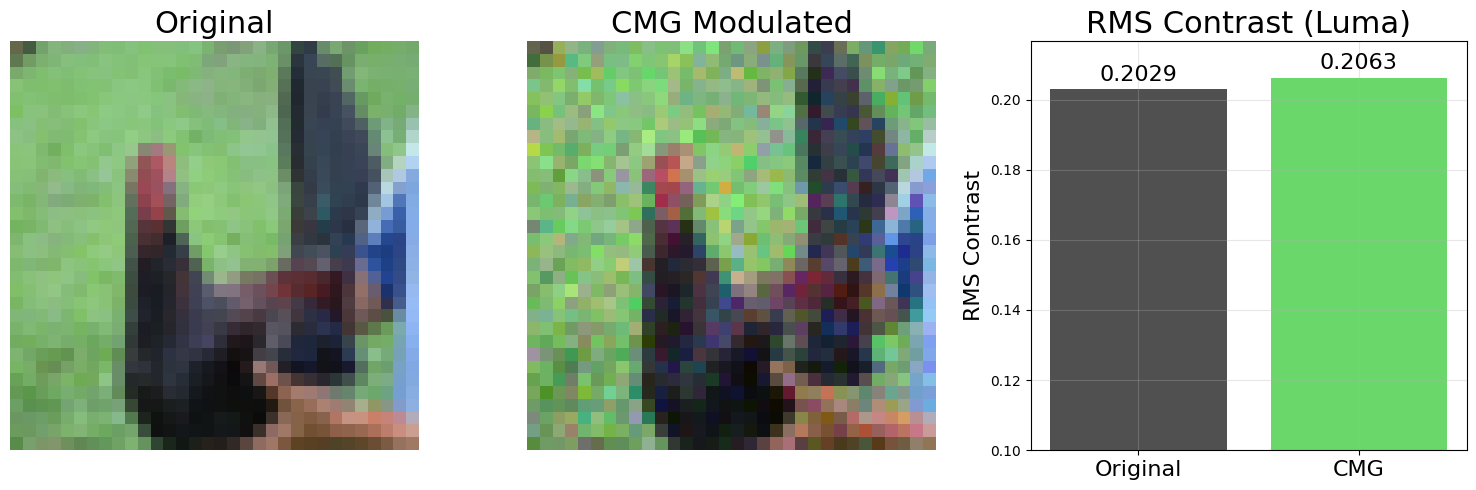


=== Analysis Summary for Bird ===
Global contrast (RMS on grayscale/luma):
  Original = 0.202912
  CM-GLLF  = 0.206279
  Change   = +1.66%

Grayscale (luma) intensity statistics:
  Original: Mean = 0.467979, Std = 0.202912
  CM-GLLF:  Mean = 0.468079, Std = 0.206279
  Mean Change: +0.02%
  Std Change:  +1.66%


In [19]:
gllf_best_params = get_best_model(dataset='CIFAR10',
                network='MLP_CIFAR10_A',
                mode='CM-GLLF-all-valuewise-minmax-mapping',
                scheduler='power_to_linear',
                epochs=150,
                seeds=[0,1,2],
                init_method='uniform')

# for class_name in ['dog','frog','horse','airplane','truck','bird','cat','deer','ship']:
for class_name in ['frog','bird',]:
    create_detailed_comparison_figure(gllf_best_params['tuner'], class_name=class_name,normalize_way='clamp',show_gray=False)
# summary = create_multi_class_comparison_figure(
#     tuner=gllf_best_params['tuner'],
#     class_names=['frog','bird'],
#     normalize_way='clamp',
#     title='CMG vs. Original across classes'
# )

In [20]:
def create_multi_class_comparison_figure(tuner, class_names, show_gray=False, normalize_way='clamp', dataset_root='./data',
                                             title=None, row_height=5.0, figsize_width=20.0, kde_points=200, verbose=False):
    """Create a stacked comparison figure for multiple classes using CM-GLLF outputs.

    Each row reproduces the four-panel layout of ``create_detailed_comparison_figure``:
    original image, CM-GLLF image, RMS contrast bar, and luma distribution. Column titles
    are shared across rows. A summary table with per-class statistics is returned.

    Parameters
    ----------
    tuner : torch.nn.Module
        Trained CM-GLLF tuner.
    class_names : Sequence[str] or str
        CIFAR-10 class names to visualize. A single string is promoted to a list.
    show_gray : bool, optional
        Display grayscale versions of the images instead of RGB.
    normalize_way : {'clamp', 'rescale', 'rescale_all'}, optional
        Method used to map normalized tensors back into display space (matches
        ``create_detailed_comparison_figure``).
    dataset_root : str, optional
        Location where CIFAR-10 is stored or downloaded.
    title : str or None, optional
        Optional suptitle for the entire figure.
    row_height : float, optional
        Height in inches allocated per class row.
    figsize_width : float, optional
        Width in inches of the full figure.
    kde_points : int, optional
        Number of evaluation points for the KDE curves.
    verbose : bool, optional
        When True, prints min/max ranges encountered during normalization.

    Returns
    -------
    pandas.DataFrame
        Summary statistics per class (RMS contrast and luma means).
    """
    import torch
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from torchvision import datasets, transforms
    from torchvision.transforms.functional import rgb_to_grayscale
    from scipy.stats import gaussian_kde

    if isinstance(class_names, str):
        class_names = [class_names]
    if not class_names:
        raise ValueError("class_names must contain at least one entry.")

    device = torch.device('cpu')
    tuner = tuner.to(device).eval()

    mean = torch.tensor([0.4914, 0.4822, 0.4465], dtype=torch.float32, device=device).view(3, 1, 1)
    std = torch.tensor([0.2470, 0.2435, 0.2616], dtype=torch.float32, device=device).view(3, 1, 1)

    dataset = datasets.CIFAR10(root=dataset_root, train=False, download=True, transform=transforms.ToTensor())
    available_classes = set(dataset.classes)
    missing = [cls for cls in class_names if cls not in available_classes]
    if missing:
        raise ValueError(f"Unknown classes {missing}. Available classes: {dataset.classes}")

    needed = set(class_names)
    class_samples = {}
    for image, label in dataset:
        cls_name = dataset.classes[label]
        if cls_name in needed and cls_name not in class_samples:
            class_samples[cls_name] = image.to(device)
            if len(class_samples) == len(needed):
                break

    if len(class_samples) != len(needed):
        unresolved = sorted(needed.difference(class_samples.keys()))
        raise RuntimeError(f"Failed to collect samples for classes: {unresolved}")

    def _apply_tuner(module, normalized_tensor):
        flat = normalized_tensor.view(1, -1)
        with torch.no_grad():
            transformed_flat = module(flat)
        return transformed_flat.view_as(normalized_tensor)

    def _unnormalize(tensor):
        return tensor * std + mean

    def _normalize_display(tensor):
        unnormalized = _unnormalize(tensor).detach()
        min_val = float(unnormalized.min())
        max_val = float(unnormalized.max())

        if verbose:
            print(f"[{normalize_way}] range: [{min_val:.6f}, {max_val:.6f}]")

        if normalize_way == 'clamp':
            return unnormalized.clamp(0.0, 1.0)
        elif normalize_way == 'rescale':
            if (min_val > 0.0) and (max_val < 1.0):
                if verbose:
                    print("Values already in (0,1); skipping min-max rescale.")
                return unnormalized.clamp(0.0, 1.0)
            if max_val > min_val:
                if verbose:
                    print("Applying per-image min-max rescale.")
                return (unnormalized - min_val) / (max_val - min_val)
            if verbose:
                print("Nearly constant tensor; returning zeros.")
            return torch.zeros_like(unnormalized)
        elif normalize_way == 'rescale_all':
            if max_val > min_val:
                if verbose:
                    print("Applying per-image min-max rescale (rescale_all).")
                return (unnormalized - min_val) / (max_val - min_val)
            if verbose:
                print("Nearly constant tensor; returning zeros.")
            return torch.zeros_like(unnormalized)
        else:
            raise ValueError("Invalid normalize_way. Choose from {'clamp', 'rescale', 'rescale_all'}.")

    def _rms_contrast(gray_tensor):
        flat = gray_tensor.view(-1)
        mean_intensity = flat.mean()
        return torch.sqrt(torch.mean((flat - mean_intensity) ** 2)).item()

    num_rows = len(class_names)
    fig_height = max(row_height * num_rows, row_height)
    fig, axes = plt.subplots(num_rows, 4, figsize=(figsize_width, fig_height))
    if num_rows == 1:
        axes = axes[np.newaxis, :]

    summary_rows = []

    for row_idx, class_name in enumerate(class_names):
        image = class_samples[class_name]
        normalized = (image - mean) / std
        transformed = _apply_tuner(tuner, normalized)

        original_display = _normalize_display(normalized)
        transformed_display = _normalize_display(transformed)

        original_gray = rgb_to_grayscale(original_display, num_output_channels=1).squeeze(0)
        transformed_gray = rgb_to_grayscale(transformed_display, num_output_channels=1).squeeze(0)

        orig_mean = float(original_gray.mean().item())
        trans_mean = float(transformed_gray.mean().item())

        if show_gray:
            original_img = original_gray.detach().cpu().numpy()
            transformed_img = transformed_gray.detach().cpu().numpy()
            cmap = 'gray'
        else:
            original_img = original_display.detach().cpu().permute(1, 2, 0).numpy()
            transformed_img = transformed_display.detach().cpu().permute(1, 2, 0).numpy()
            cmap = None

        axes[row_idx, 0].imshow(original_img if cmap else np.clip(original_img, 0, 1), cmap=cmap, vmin=0.0, vmax=1.0)
        # axes[row_idx, 0].set_title(f'Original', fontsize=22)
        axes[row_idx, 0].axis('off')

        axes[row_idx, 1].imshow(transformed_img if cmap else np.clip(transformed_img, 0, 1), cmap=cmap, vmin=0.0, vmax=1.0)
        # axes[row_idx, 1].set_title(f'CMG Transformed', fontsize=22)
        axes[row_idx, 1].axis('off')

        original_rms = _rms_contrast(original_gray)
        transformed_rms = _rms_contrast(transformed_gray)

        bars = axes[row_idx, 2].bar(['Original', 'CMG'], [original_rms, transformed_rms],
                                     color=['#060606', "#2bc62b"], alpha=0.7)
        axes[row_idx, 2].set_ylabel('RMS contrast (luma)', fontsize=16)
        axes[row_idx, 2].grid(True, alpha=0.3)
        axes[row_idx, 2].tick_params(axis='x', labelsize=16) 
        for bar, value in zip(bars, [original_rms, transformed_rms]):
            height = bar.get_height()
            axes[row_idx, 2].annotate(f'{value:.4f}',
                                     (bar.get_x() + bar.get_width() / 2, height),
                                     xytext=(0, 3), textcoords='offset points',
                                     ha='center', va='bottom', fontsize=16)

        orig_gray_flat = original_gray.detach().cpu().numpy().flatten()
        trans_gray_flat = transformed_gray.detach().cpu().numpy().flatten()
        x = np.linspace(0.0, 1.0, kde_points)
        kde_orig = gaussian_kde(orig_gray_flat)
        kde_trans = gaussian_kde(trans_gray_flat)
        axes[row_idx, 3].plot(x, kde_orig(x), label='Original', color='#060606', linewidth=2)
        axes[row_idx, 3].plot(x, kde_trans(x), label='CMG', color='green', linewidth=2)
        axes[row_idx, 3].set_xlim(0.0, 1.0)
        axes[row_idx, 3].set_xlabel("Luma", fontsize=16)
        axes[row_idx, 3].set_ylabel('Density', fontsize=16)
        axes[row_idx, 3].grid(True, alpha=0.3)
        if row_idx == 0:
            axes[row_idx, 3].legend(fontsize=16)

        axes[row_idx, 0].text(-0.12, 0.5, class_name.capitalize(), transform=axes[row_idx, 0].transAxes,
                              fontsize=14, rotation=90, ha='center', va='center')

        summary_rows.append({
            'class': class_name,
            'rms_original': original_rms,
            'rms_cmg': transformed_rms,
            'rms_difference': transformed_rms - original_rms,
            'mean_luma_original': orig_mean,
            'mean_luma_cmg': trans_mean,
            'mean_difference': trans_mean - orig_mean
        })

    axes[0, 0].set_title('Original', fontsize=22)
    axes[0, 1].set_title('CMG transformed', fontsize=22)
    axes[0, 2].set_title('RMS contrast (Luma)', fontsize=22)
    axes[0, 3].set_title('Luma distribution', fontsize=22)

    if title:
        fig.suptitle(title, fontsize=18)

    plt.tight_layout(rect=(0, 0, 1, 0.97) if title else None)

    summary_df = pd.DataFrame(summary_rows).set_index('class')
    return summary_df

In [21]:
import torch
import numpy as np
import pandas as pd
from torchvision import datasets, transforms
from torchvision.transforms.functional import rgb_to_grayscale
from torch.utils.data import DataLoader, Subset
from scipy import stats
from collections import defaultdict


def analyze_global_contrast_statistics(tuner, dataset_root='./data', normalize_way='clamp', max_images=None, batch_size=512, num_workers=2):
    """
    Compute dataset-wide RMS contrast statistics before and after CM-GLLF.

    Parameters
    ----------
    tuner : torch.nn.Module
        Trained CM-GLLF tuner to evaluate.
    dataset_root : str, optional
        Location to download/load CIFAR-10.
    normalize_way : str, optional
        Strategy used to map normalized tensors back into display space. Options:
        'clamp', 'rescale', or 'rescale_all'.
    max_images : int or None, optional
        If provided, limits the number of images analyzed (for quick tests).
    batch_size : int, optional
        Mini-batch size used for processing images through the tuner.
    num_workers : int, optional
        Number of subprocesses for data loading.
    """
    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    tuner = tuner.to(device).eval()

    mean = torch.tensor([0.4914, 0.4822, 0.4465], dtype=torch.float32, device=device).view(3, 1, 1)
    std = torch.tensor([0.2470, 0.2435, 0.2616], dtype=torch.float32, device=device).view(3, 1, 1)

    dataset = datasets.CIFAR10(
        root=dataset_root,
        train=False,
        download=True,
        transform=transforms.ToTensor()
    )

    total_available = len(dataset)
    total_images = total_available if max_images is None else min(max_images, total_available)
    indices = list(range(total_images))
    data_subset = Subset(dataset, indices)
    loader = DataLoader(data_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    def _unnormalize(tensor):
        return tensor * std + mean

    def _to_display_batch(tensor_batch):
        unnormalized = _unnormalize(tensor_batch)
        if normalize_way == 'clamp':
            return unnormalized.clamp(0.0, 1.0)
        elif normalize_way in {'rescale', 'rescale_all'}:
            flat = unnormalized.view(unnormalized.size(0), -1)
            mins = flat.min(dim=1)[0].view(-1, 1, 1, 1)
            maxs = flat.max(dim=1)[0].view(-1, 1, 1, 1)
            ranges = maxs - mins
            safe_ranges = torch.where(ranges < 1e-8, torch.ones_like(ranges), ranges)
            normalized = (unnormalized - mins) / safe_ranges
            zero_tensor = torch.zeros_like(normalized)
            return torch.where(ranges < 1e-8, zero_tensor, normalized)
        else:
            raise ValueError(f"Unsupported normalize_way '{normalize_way}'.")

    def _rms_contrast_batch(gray_tensor):
        # RMS contrast = std dev of grayscale (luma) intensities per image
        flat = gray_tensor.view(gray_tensor.size(0), -1)
        means = flat.mean(dim=1, keepdim=True)
        return torch.sqrt(((flat - means) ** 2).mean(dim=1))

    original_contrasts_list = []
    transformed_contrasts_list = []
    label_batches = []
    class_stats = defaultdict(lambda: {'total': 0, 'improved': 0, 'decreased': 0, 'tied': 0})

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        normalized = (images - mean) / std
        with torch.no_grad():
            transformed = tuner(normalized.view(images.size(0), -1)).view_as(normalized)

        original_display = _to_display_batch(normalized)
        transformed_display = _to_display_batch(transformed)

        original_gray = rgb_to_grayscale(original_display, num_output_channels=1).squeeze(1)
        transformed_gray = rgb_to_grayscale(transformed_display, num_output_channels=1).squeeze(1)

        orig_contrast_batch = _rms_contrast_batch(original_gray)
        trans_contrast_batch = _rms_contrast_batch(transformed_gray)

        orig_contrast_np = orig_contrast_batch.cpu().numpy()
        trans_contrast_np = trans_contrast_batch.cpu().numpy()
        labels_np = labels.cpu().numpy()

        original_contrasts_list.append(orig_contrast_np)
        transformed_contrasts_list.append(trans_contrast_np)
        label_batches.append(labels_np)

        for orig_c, trans_c, label_idx in zip(orig_contrast_np, trans_contrast_np, labels_np):
            class_name = dataset.classes[label_idx]
            class_stats[class_name]['total'] += 1
            if trans_c > orig_c:
                class_stats[class_name]['improved'] += 1
            elif trans_c < orig_c:
                class_stats[class_name]['decreased'] += 1
            else:
                class_stats[class_name]['tied'] += 1

    original_contrasts = np.concatenate(original_contrasts_list) if original_contrasts_list else np.array([])
    transformed_contrasts = np.concatenate(transformed_contrasts_list) if transformed_contrasts_list else np.array([])
    all_labels = np.concatenate(label_batches) if label_batches else np.array([])

    contrast_diff = transformed_contrasts - original_contrasts
    improved_mask = contrast_diff > 0
    decreased_mask = contrast_diff < 0
    tied_mask = contrast_diff == 0

    improved_count = int(improved_mask.sum())
    decreased_count = int(decreased_mask.sum())
    tied_count = int(tied_mask.sum())

    mean_original = float(np.mean(original_contrasts)) if original_contrasts.size else float('nan')
    mean_transformed = float(np.mean(transformed_contrasts)) if transformed_contrasts.size else float('nan')
    mean_diff = float(np.mean(contrast_diff)) if contrast_diff.size else float('nan')

    if contrast_diff.size > 1:
        std_diff = float(np.std(contrast_diff, ddof=1))
        t_stat, p_two_sided = stats.ttest_rel(transformed_contrasts, original_contrasts)
        df = contrast_diff.size - 1
        # One-sided p-value for alternative: CM-GLLF > Original
        p_value_one_sided = float(stats.t.sf(t_stat, df))
        # Cohen's dz (paired) = mean(diff) / std(diff)
        effect_size = mean_diff / std_diff if std_diff > 0 else float('nan')
        ci_half_width = stats.t.ppf(0.975, df) * (std_diff / np.sqrt(contrast_diff.size)) if std_diff > 0 else float('nan')
        ci_low = mean_diff - ci_half_width if std_diff > 0 else float('nan')
        ci_high = mean_diff + ci_half_width if std_diff > 0 else float('nan')
    else:
        std_diff = float('nan')
        t_stat = float('nan')
        p_two_sided = float('nan')
        p_value_one_sided = float('nan')
        effect_size = float('nan')
        ci_low = float('nan')
        ci_high = float('nan')

    per_class_rows = []
    for class_name in dataset.classes:
        stats_row = class_stats[class_name]
        total = stats_row['total']
        per_class_rows.append({
            'class': class_name,
            'total': stats_row['total'],
            'improved': stats_row['improved'],
            'decreased': stats_row['decreased'],
            'tied': stats_row['tied'],
            'improved_pct': (stats_row['improved'] / total) if total > 0 else np.nan
        })

    per_class_summary = pd.DataFrame(per_class_rows).set_index('class')

    summary = {
        'total_images': int(total_images),
        'improved_count': improved_count,
        'decreased_count': decreased_count,
        'tied_count': tied_count,
        'improved_rate': improved_count / total_images if total_images else float('nan'),
        'mean_original_contrast': mean_original,
        'mean_transformed_contrast': mean_transformed,
        'mean_difference': mean_diff,
        'effect_size_dz': effect_size,
        't_statistic': t_stat,
        'p_value_two_sided': p_two_sided,
        'p_value_one_sided': p_value_one_sided,
        'confidence_interval_95': (ci_low, ci_high),
        'per_class_summary': per_class_summary
    }

    return summary


contrast_stats = analyze_global_contrast_statistics(
    tuner=gllf_best_params['tuner'],
    dataset_root='./data',
    normalize_way='clamp',
    max_images=None,
    batch_size=512,
    num_workers=4
)

print(f"Images analyzed: {contrast_stats['total_images']}")
print(f"Improved contrast: {contrast_stats['improved_count']} ({contrast_stats['improved_rate']*100:.2f}%)")
print(f"Decreased contrast: {contrast_stats['decreased_count']}")
print(f"No change: {contrast_stats['tied_count']}")
print(f"Mean RMS contrast (original): {contrast_stats['mean_original_contrast']:.6f}")
print(f"Mean RMS contrast (CM-GLLF): {contrast_stats['mean_transformed_contrast']:.6f}")
print(f"Mean difference: {contrast_stats['mean_difference']:.6f}")
print(f"Paired t-test (one-sided, CM-GLLF > original): t = {contrast_stats['t_statistic']:.4f}, p = {contrast_stats['p_value_one_sided']:.3e}")
print(f"Paired t-test (two-sided): p = {contrast_stats['p_value_two_sided']:.3e}")
print(f"Effect size (Cohen's dz, paired): {contrast_stats['effect_size_dz']:.4f}")
ci_low, ci_high = contrast_stats['confidence_interval_95']
print(f"95% CI for mean difference: [{ci_low:.6f}, {ci_high:.6f}]")

display(contrast_stats['per_class_summary'].style.format({
    'improved_pct': '{:.2%}'
}))

Files already downloaded and verified


OutOfMemoryError: CUDA out of memory. Tried to allocate 5.86 GiB. GPU 0 has a total capacity of 47.54 GiB of which 3.95 GiB is free. Process 2690425 has 18.44 GiB memory in use. Process 2723979 has 18.44 GiB memory in use. Including non-PyTorch memory, this process has 6.71 GiB memory in use. Of the allocated memory 5.89 GiB is allocated by PyTorch, and 6.21 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Generate Excel Files with Hyperparameter Results

## Notes on qualitative metrics and tests
- RMS contrast: computed as the standard deviation of grayscale intensities (luma). This is appropriate for image-wide contrast when mean luminance varies.
- Luma vs. luminance: we use grayscale luma as a perceptual proxy for luminance via rgb_to_grayscale (BT.601-like weights). If you prefer, call the plot "grayscale luma intensity distribution" or simply "grayscale intensity distribution".
- "Luminance distribution" wording is acceptable in vision contexts, but "grayscale intensity (luma) distribution" is more precise for sRGB images in code.
- Paired t-test: compares the mean of within-image differences (CM-GLLF minus Original RMS contrast). The t-statistic is mean(diff)/(sd(diff)/sqrt(n)); the p-value quantifies evidence against no mean change. One-sided p tests CM-GLLF > Original; two-sided tests any change. Assumptions: pairs are matched per image, differences are approximately normal or n is large (CLT).

In [ ]:
def create_hyperparameter_table(dataset, network, mode, scheduler, epochs, seeds, init_method=None,
                               lrs=[0.025, 0.01, 0.001], batch_sizes=[32, 64, 128], 
                               weight_decay=5e-4, is_tuned=True):
    """
    Create a table of average accuracies for different hyperparameter combinations.
    Returns a pandas DataFrame with batch_sizes as rows and learning rates as columns.
    """
    import pandas as pd
    
    # Initialize results dictionary
    results = {}
    
    for bs in batch_sizes:
        results[bs] = {}
        for lr in lrs:
            combo_accs = []
            
            for seed in seeds:
                try:
                    if is_tuned:
                        # Get file path for tuned model
                        result_path, _ = get_fname_tuner(
                            dataset, network, bs, lr, lr, epochs, seed,
                            True, mode, True, init_method, weight_decay,
                            False, False, scheduler_w=scheduler
                        )
                    else:
                        # Get file path for untuned model
                        result_path, _ = get_fname_tuner(
                            dataset, network, bs, lr, None, epochs, seed,
                            False, None, False, None, weight_decay, 
                            False, False, scheduler_w=scheduler
                        )
                    
                    # Load test results
                    test_file = os.path.join(result_path, 'res_test.mat')
                    
                    if os.path.exists(test_file):
                        test_data = recover_dict(loadmat(test_file))
                        max_test_acc = np.max(test_data["top1"])
                        combo_accs.append(max_test_acc)
                
                except Exception as e:
                    print(f"Error processing {dataset}-{network}-{mode}-bs{bs}-lr{lr}-seed{seed}: {e}")
                    continue
            
            # Calculate average accuracy for this combination
            if combo_accs:
                avg_acc = np.mean(combo_accs)
                std_acc = np.std(combo_accs)
                results[bs][lr] = f"{avg_acc:.2f}"
            else:
                results[bs][lr] = "N/A"
    
    # Convert to DataFrame
    df = pd.DataFrame(results).T  # Transpose so batch_sizes are rows
    df.index.name = 'Batch Size\\LR'
    df.columns = [f'{lr}' for lr in lrs]
    
    return df

In [ ]:
def create_excel_for_dataset(dataset, network, scheduler, epochs, seeds, 
                            modes_and_init_methods, output_dir='excel_results'):
    """
    Create an Excel file for a dataset with separate sheets for each mode and the original MLP.
    """
    import pandas as pd
    from openpyxl import Workbook
    from openpyxl.styles import Font, PatternFill, Border, Side, Alignment
    from openpyxl.utils.dataframe import dataframe_to_rows
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Create Excel file
    excel_filename = os.path.join(output_dir, f'{dataset}_hyperparameter_results.xlsx')
    
    with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
        
        # Add sheet for original MLP (no tuner)
        print(f"Processing Original MLP for {dataset}...")
        original_df = create_hyperparameter_table(
            dataset, network, None, scheduler, epochs, seeds, 
            init_method=None, is_tuned=False
        )
        original_df.to_excel(writer, sheet_name='Original_MLP')
        
        # Add sheets for each tuned mode
        for mode, init_method in modes_and_init_methods:
            print(f"Processing {mode} for {dataset}...")
            try:
                tuned_df = create_hyperparameter_table(
                    dataset, network, mode, scheduler, epochs, seeds, 
                    init_method=init_method, is_tuned=True
                )
                
                # Clean sheet name (Excel has character limits and restrictions)
                sheet_name = mode.replace('-', '_')[:30]  # Limit to 30 chars
                tuned_df.to_excel(writer, sheet_name=sheet_name)
                
            except Exception as e:
                print(f"Error processing {mode}: {e}")
                continue
    
    # Apply formatting to the Excel file
    wb = writer.book if hasattr(writer, 'book') else None
    if wb is None:
        # Re-open the file for formatting
        from openpyxl import load_workbook
        wb = load_workbook(excel_filename)
    
    # Format each sheet
    for sheet_name in wb.sheetnames:
        ws = wb[sheet_name]
        
        # Header formatting
        header_font = Font(bold=True, color="FFFFFF")
        header_fill = PatternFill(start_color="366092", end_color="366092", fill_type="solid")
        
        # Apply formatting to header row and column
        for cell in ws[1]:  # First row
            if cell.value:
                cell.font = header_font
                cell.fill = header_fill
                cell.alignment = Alignment(horizontal="center")
        
        for cell in ws['A']:  # First column
            if cell.value and cell.row > 1:
                cell.font = Font(bold=True)
                cell.alignment = Alignment(horizontal="center")
        
        # Auto-adjust column widths
        for column in ws.columns:
            max_length = 0
            column_letter = column[0].column_letter
            for cell in column:
                try:
                    if len(str(cell.value)) > max_length:
                        max_length = len(str(cell.value))
                except:
                    pass
            adjusted_width = min(max_length + 2, 20)
            ws.column_dimensions[column_letter].width = adjusted_width
    
    wb.save(excel_filename)
    print(f"Excel file saved: {excel_filename}")
    
    return excel_filename

In [ ]:
# Generate Excel files for all datasets
import pandas as pd

# Define the modes and their corresponding initialization methods
modes_and_init_methods = [
    ('CM-GLLF-all-valuewise-minmax-mapping', 'uniform'),
    ('linear-valuewise-positive', 'uniform'),
    ('cubic-valuewise-positive', 'uniform'),
    ('adaptive-sigmoid-valuewise', 'uniform'),
    ('adaptive-tanh-valuewise', 'uniform'),
    ('srelu_valuewise_positive', 'uniform'),
]

# Dataset configurations
datasets_config = [
    ('CIFAR10', 'MLP_CIFAR10_A'),
    ('CIFAR100', 'MLP_CIFAR100_A')
]

# Parameters
scheduler = 'power_to_linear'
epochs = 150
seeds = [0, 1, 2]

# Generate Excel files for each dataset
for dataset, network in datasets_config:
    print(f"\n{'='*50}")
    print(f"Generating Excel file for {dataset}")
    print(f"{'='*50}")
    
    excel_file = create_excel_for_dataset(
        dataset=dataset,
        network=network,
        scheduler=scheduler,
        epochs=epochs,
        seeds=seeds,
        modes_and_init_methods=modes_and_init_methods
    )
    
    print(f"Completed: {excel_file}")

print(f"\n{'='*50}")
print("All Excel files generated successfully!")
print(f"{'='*50}")


Generating Excel file for CIFAR10
Processing Original MLP for CIFAR10...
Processing CM-GLLF-all-valuewise-minmax-mapping for CIFAR10...
Processing linear-valuewise-positive for CIFAR10...
Processing cubic-valuewise-positive for CIFAR10...
Processing adaptive-sigmoid-valuewise for CIFAR10...
Processing adaptive-tanh-valuewise for CIFAR10...
Processing srelu_valuewise_positive for CIFAR10...
Excel file saved: excel_results/CIFAR10_hyperparameter_results.xlsx
Completed: excel_results/CIFAR10_hyperparameter_results.xlsx

Generating Excel file for CIFAR100
Processing Original MLP for CIFAR100...
Processing CM-GLLF-all-valuewise-minmax-mapping for CIFAR100...
Processing linear-valuewise-positive for CIFAR100...
Processing cubic-valuewise-positive for CIFAR100...
Processing adaptive-sigmoid-valuewise for CIFAR100...
Processing adaptive-tanh-valuewise for CIFAR100...
Processing srelu_valuewise_positive for CIFAR100...
Excel file saved: excel_results/CIFAR100_hyperparameter_results.xlsx
Comple